In [1]:
# Imported Libraries
import numpy as np
import pandas as pd 
import copy
from collections import Counter
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.compose import ColumnTransformer 
from imblearn.pipeline import Pipeline

#Sampling Libraries
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# Model Libraries
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, StratifiedKFold

# Visual Libraries
from matplotlib import pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

# Performance metrics libraries
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve,auc
from sklearn.model_selection import ParameterGrid

# Tensorflow
import tensorflow as tf
from keras.models import Model, Sequential, load_model
from keras.layers import Input, Dense, Lambda
from keras.losses import mse
from keras import regularizers
from keras import backend as K

from VAE import VAE_oversampling
from GAN import GAN
from CV import *
import warnings
warnings.filterwarnings('ignore')

In [2]:
#Setting the random seed 
import random
seed = 42
np.random.seed(seed) 
tf.random.set_seed(42)
random.seed(seed)

In [3]:
df = pd.read_csv('creditcard.csv')
df.head()

Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V27       V28  Amount  Class  
0 -0.189115  0.133558 -0.021053  149.62      0  
1  0.125895 -0.008983  0.014724    2.69      0  
2 -0.139097 -0.055353 -0.059752  378.66      0  
3 -0.221929  0.062723  0.061458  123.50      0  
4  0.502292  0.219422  0.215153   69.99      0  

[5 rows x 31 columns]

### Train, Validate, Test split

In [4]:
X = df.drop(['Class'], axis=1)
y = df['Class']

#Split data initially to train and remainingfor cross
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=0.8, stratify=y)

# Check the number of records
print('The number of records in the training dataset is', X_train.shape[0])
print('The number of records in the validation dataset is', X_test.shape[0])
print(f"The training dataset has {sorted(Counter(y_train).items())[0][1]} records for the majority class and {sorted(Counter(y_train).items())[1][1]} records for the minority class.")
print(f"The validation and test datasets have {sorted(Counter(y_test).items())[0][1]} records for the majority class and {sorted(Counter(y_test).items())[1][1]} records for the minority class.")

The number of records in the training dataset is 227845
The number of records in the validation dataset is 56962
The training dataset has 227451 records for the majority class and 394 records for the minority class.
The validation and test datasets have 56864 records for the majority class and 98 records for the minority class.


In [5]:
# Parameters and values to tune
param_grid_nb = dict(classifier__var_smoothing = np.logspace(0,-9, num=5))

## Original Dataset Results

Original applied
Accuracy:, 0.992807 (+/- 0.000425)
Precision: 0.144342 (+/- 0.007954)
Recall: 0.639468 (+/- 0.034101)
F1 score: 0.235410 (+/- 0.011982)
ROC_AUC: 0.967843 (+/- 0.011961)
Best hyperparameters:  {'classifier__var_smoothing': 1e-09}

Classified 	65 out of 98 	fraud cases correctly
Misclassified 	407 out of 56864 normal cases
Accuracy: 0.9922755521224677
Precision: 0.13771186440677965
Recall: 0.6632653061224489
F1 score: 0.2280701754385965
ROC_AUC: 0.8280539389362949


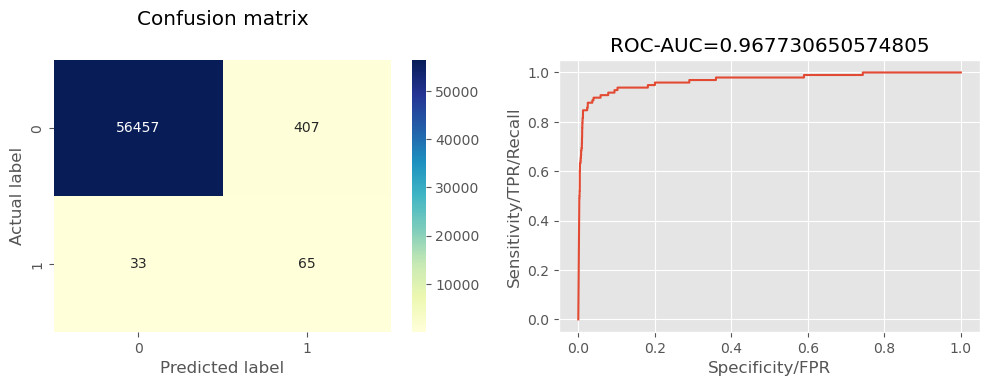

In [18]:
gs = model_cv(X_train, y_train, GaussianNB(), 'f1', param_grid_nb, 'original')

evaluate_model(X_test, y_test, gs)

## Scaled

Accuracy:, 0.988628 (+/- 0.000602)
Precision: 0.108833 (+/- 0.005372)
Recall: 0.773969 (+/- 0.029542)
F1 score: 0.190782 (+/- 0.008666)
ROC_AUC: 0.965141 (+/- 0.010060)
Best hyperparameters:  {'classifier__var_smoothing': 1.0}

Classified 	79 out of 98 	fraud cases correctly
Misclassified 	673 out of 56864 normal cases
Accuracy: 0.9878515501562445
Precision: 0.10505319148936171
Recall: 0.8061224489795918
F1 score: 0.1858823529411765
ROC_AUC: 0.8971435964650352


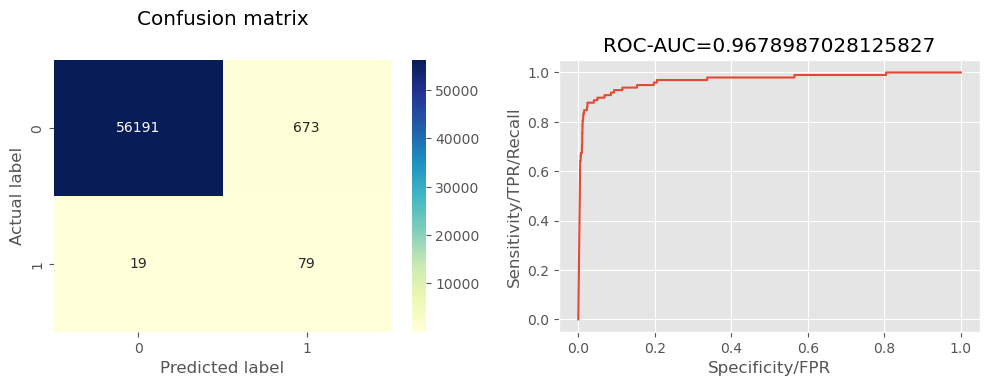

In [19]:
gs = model_cv(X_train, y_train, GaussianNB(), 'f1', param_grid_nb)

evaluate_model(X_test, y_test, gs)

## Random Undersampling

Accuracy:, 0.998767 (+/- 0.000121)
Precision: 0.749151 (+/- 0.056358)
Recall: 0.431353 (+/- 0.043498)
F1 score: 0.546902 (+/- 0.047392)
ROC_AUC: 0.976782 (+/- 0.009445)
Best hyperparameters:  {'classifier__var_smoothing': 1.0}

Classified 	47 out of 98 	fraud cases correctly
Misclassified 	23 out of 56864 normal cases
Accuracy: 0.9987008883115059
Precision: 0.6714285714285714
Recall: 0.47959183673469385
F1 score: 0.5595238095238094
ROC_AUC: 0.7395936814511962


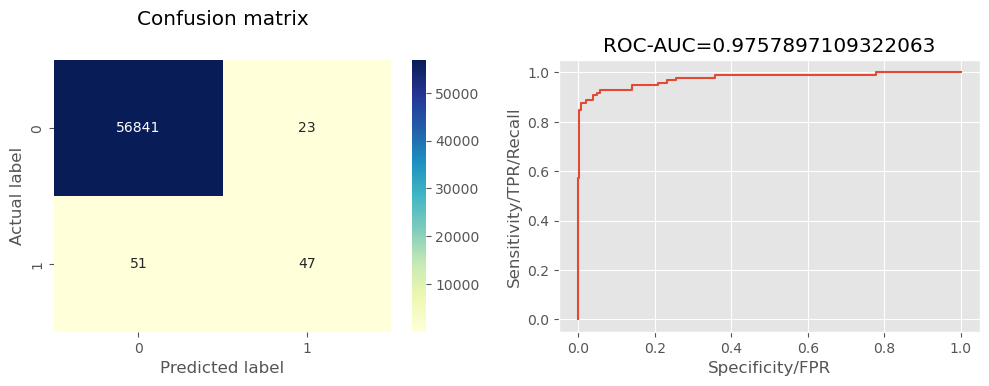

In [20]:
gs = model_cv(X_train, y_train, GaussianNB(), "f1", param_grid_nb, 'undersampling')

evaluate_model(X_test, y_test, gs)

## Oversampling with SMOTE

SMOTE applied
Accuracy:, 0.998819 (+/- 0.000135)
Precision: 0.776865 (+/- 0.057142)
Recall: 0.444044 (+/- 0.052786)
F1 score: 0.564384 (+/- 0.055164)
ROC_AUC: 0.976191 (+/- 0.009872)
Best hyperparameters:  {'classifier__var_smoothing': 1.0}

Classified 	47 out of 98 	fraud cases correctly
Misclassified 	19 out of 56864 normal cases
Accuracy: 0.9987711105649381
Precision: 0.7121212121212122
Recall: 0.47959183673469385
F1 score: 0.573170731707317
ROC_AUC: 0.7396288530887876


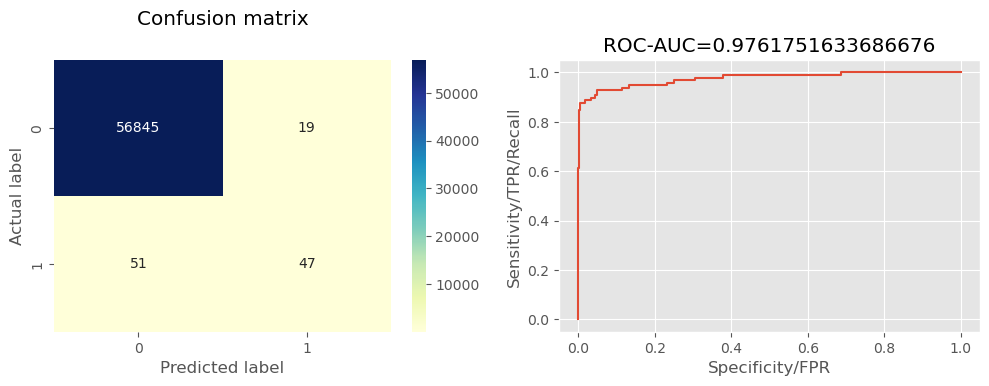

In [21]:
gs = model_cv(X_train, y_train, GaussianNB(), 'f1', param_grid_nb, 'smote')

evaluate_model(X_test, y_test, gs)

## Oversampling with VAE

### Hyperparameter Tuning with cross validation

############################### Parameters tested: {'var_smoothing': 1.0} ################################
------------------------ KFold: 1 ---------------------------
The training dataset has 181960 records for the majority class and 316 records for the minority class.
The test dataset has 45491 records for the majority class and 78 records for the minority class.
Number of samples to be generated:  181644
Epoch 1/100
284/284 [==============================] - 2s 4ms/step - loss: 34.3037 - val_loss: 28.3303
Epoch 2/100
284/284 [==============================] - 1s 3ms/step - loss: 29.6595 - val_loss: 25.9898
Epoch 3/100
284/284 [==============================] - 1s 3ms/step - loss: 28.5668 - val_loss: 26.2786
Epoch 4/100
284/284 [==============================] - 1s 3ms/step - loss: 28.3222 - val_loss: 25.4520
Epoch 5/100
284/284 [==============================] - 1s 3ms/step - loss: 28.0240 - val_loss: 25.3987
Epoch 6/100
284/284 [==============================] - 1s 3ms/step - loss

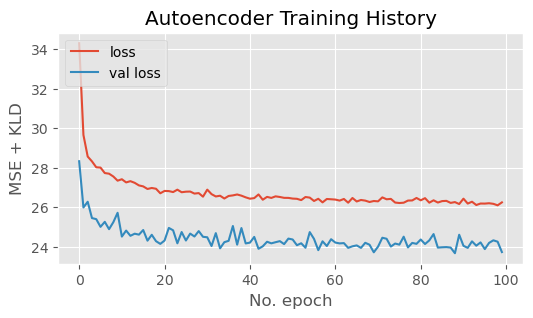

5677/5677 [==============================] - 9s 2ms/step
------------------------ KFold: 2 ---------------------------
The training dataset has 181961 records for the majority class and 315 records for the minority class.
The test dataset has 45490 records for the majority class and 79 records for the minority class.
Number of samples to be generated:  181646
Epoch 1/100
283/283 [==============================] - 2s 4ms/step - loss: 35.2702 - val_loss: 29.0171
Epoch 2/100
283/283 [==============================] - 1s 3ms/step - loss: 30.5556 - val_loss: 25.8012
Epoch 3/100
283/283 [==============================] - 1s 3ms/step - loss: 28.7373 - val_loss: 25.3464
Epoch 4/100
283/283 [==============================] - 1s 3ms/step - loss: 28.2460 - val_loss: 24.9633
Epoch 5/100
283/283 [==============================] - 2s 8ms/step - loss: 28.3019 - val_loss: 25.0949
Epoch 6/100
283/283 [==============================] - 2s 7ms/step - loss: 27.9697 - val_loss: 24.9241
Epoch 7/100
283/283 

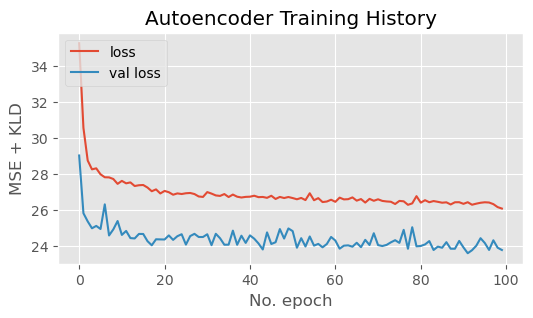

5677/5677 [==============================] - 12s 2ms/step
------------------------ KFold: 3 ---------------------------
The training dataset has 181961 records for the majority class and 315 records for the minority class.
The test dataset has 45490 records for the majority class and 79 records for the minority class.
Number of samples to be generated:  181646
Epoch 1/100
283/283 [==============================] - 2s 4ms/step - loss: 34.4010 - val_loss: 27.2977
Epoch 2/100
283/283 [==============================] - 1s 3ms/step - loss: 29.8799 - val_loss: 25.0249
Epoch 3/100
283/283 [==============================] - 1s 3ms/step - loss: 28.4367 - val_loss: 24.5742
Epoch 4/100
283/283 [==============================] - 1s 4ms/step - loss: 28.2614 - val_loss: 24.4632
Epoch 5/100
283/283 [==============================] - 1s 3ms/step - loss: 28.3323 - val_loss: 24.5896
Epoch 6/100
283/283 [==============================] - 1s 3ms/step - loss: 28.0580 - val_loss: 24.1715
Epoch 7/100
283/283

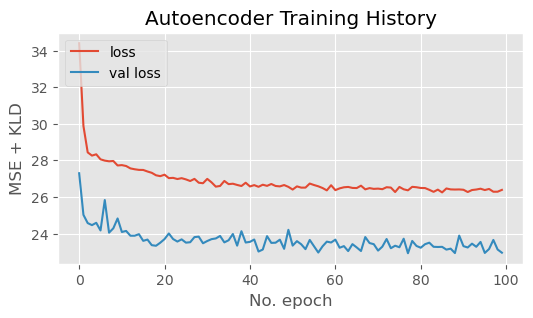

5677/5677 [==============================] - 9s 2ms/step
------------------------ KFold: 4 ---------------------------
The training dataset has 181961 records for the majority class and 315 records for the minority class.
The test dataset has 45490 records for the majority class and 79 records for the minority class.
Number of samples to be generated:  181646
Epoch 1/100
283/283 [==============================] - 3s 5ms/step - loss: 35.1304 - val_loss: 29.9839
Epoch 2/100
283/283 [==============================] - 1s 3ms/step - loss: 29.9282 - val_loss: 26.5732
Epoch 3/100
283/283 [==============================] - 1s 3ms/step - loss: 28.4824 - val_loss: 25.9608
Epoch 4/100
283/283 [==============================] - 1s 4ms/step - loss: 28.4431 - val_loss: 25.9654
Epoch 5/100
283/283 [==============================] - 3s 12ms/step - loss: 27.7701 - val_loss: 25.8064
Epoch 6/100
283/283 [==============================] - 2s 8ms/step - loss: 27.8080 - val_loss: 25.5380
Epoch 7/100
283/283

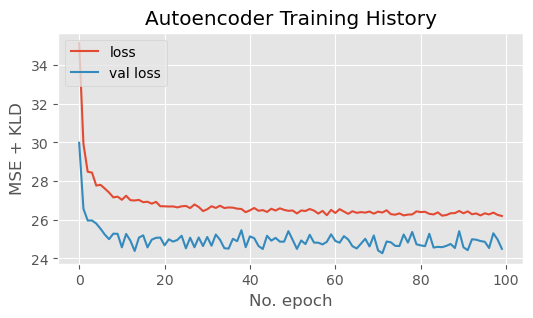

5677/5677 [==============================] - 12s 2ms/step
------------------------ KFold: 5 ---------------------------
The training dataset has 181961 records for the majority class and 315 records for the minority class.
The test dataset has 45490 records for the majority class and 79 records for the minority class.
Number of samples to be generated:  181646
Epoch 1/100
283/283 [==============================] - 2s 5ms/step - loss: 34.8786 - val_loss: 39.9832
Epoch 2/100
283/283 [==============================] - 1s 3ms/step - loss: 29.9199 - val_loss: 37.0819
Epoch 3/100
283/283 [==============================] - 1s 4ms/step - loss: 27.5623 - val_loss: 36.0579
Epoch 4/100
283/283 [==============================] - 3s 10ms/step - loss: 27.0022 - val_loss: 35.8474
Epoch 5/100
283/283 [==============================] - 2s 8ms/step - loss: 26.6980 - val_loss: 35.7176
Epoch 6/100
283/283 [==============================] - 2s 7ms/step - loss: 26.7781 - val_loss: 35.8402
Epoch 7/100
283/28

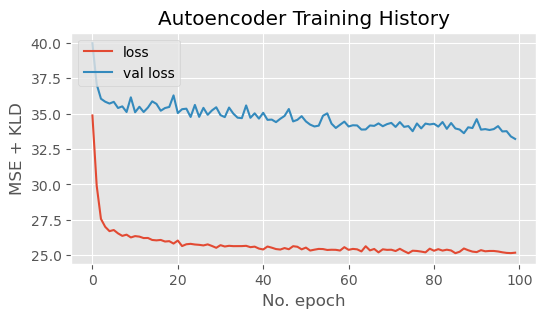

5677/5677 [==============================] - 9s 2ms/step
############################### Parameters tested: {'var_smoothing': 0.005623413251903491} ################################
------------------------ KFold: 1 ---------------------------
The training dataset has 181960 records for the majority class and 316 records for the minority class.
The test dataset has 45491 records for the majority class and 78 records for the minority class.
Number of samples to be generated:  181644
Epoch 1/100
284/284 [==============================] - 2s 4ms/step - loss: 34.5923 - val_loss: 29.5214
Epoch 2/100
284/284 [==============================] - 1s 3ms/step - loss: 29.8610 - val_loss: 25.6623
Epoch 3/100
284/284 [==============================] - 2s 6ms/step - loss: 28.4910 - val_loss: 26.3104
Epoch 4/100
284/284 [==============================] - 2s 7ms/step - loss: 28.1998 - val_loss: 25.3908
Epoch 5/100
284/284 [==============================] - 2s 6ms/step - loss: 27.8115 - val_loss: 25.1437

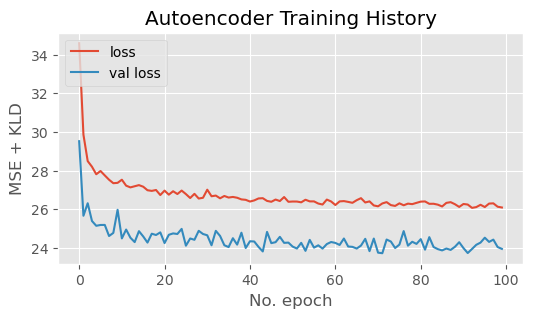

5677/5677 [==============================] - 9s 2ms/step
------------------------ KFold: 2 ---------------------------
The training dataset has 181961 records for the majority class and 315 records for the minority class.
The test dataset has 45490 records for the majority class and 79 records for the minority class.
Number of samples to be generated:  181646
Epoch 1/100
283/283 [==============================] - 2s 3ms/step - loss: 34.5871 - val_loss: 28.0321
Epoch 2/100
283/283 [==============================] - 1s 3ms/step - loss: 30.0471 - val_loss: 26.3741
Epoch 3/100
283/283 [==============================] - 1s 5ms/step - loss: 28.7470 - val_loss: 25.2666
Epoch 4/100
283/283 [==============================] - 2s 7ms/step - loss: 28.2992 - val_loss: 24.9697
Epoch 5/100
283/283 [==============================] - 2s 6ms/step - loss: 28.4534 - val_loss: 24.9497
Epoch 6/100
283/283 [==============================] - 2s 5ms/step - loss: 28.0829 - val_loss: 24.5509
Epoch 7/100
283/283 

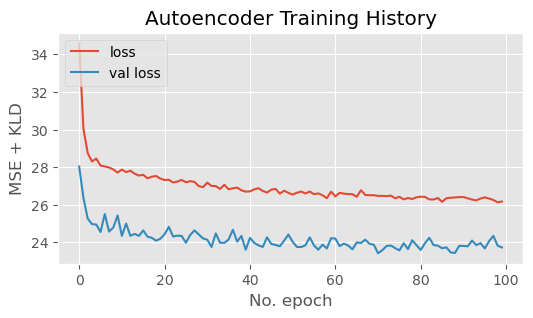

5677/5677 [==============================] - 10s 2ms/step
------------------------ KFold: 3 ---------------------------
The training dataset has 181961 records for the majority class and 315 records for the minority class.
The test dataset has 45490 records for the majority class and 79 records for the minority class.
Number of samples to be generated:  181646
Epoch 1/100
283/283 [==============================] - 2s 4ms/step - loss: 35.1207 - val_loss: 29.1921
Epoch 2/100
283/283 [==============================] - 1s 3ms/step - loss: 30.5622 - val_loss: 25.6670
Epoch 3/100
283/283 [==============================] - 2s 6ms/step - loss: 28.6013 - val_loss: 24.5236
Epoch 4/100
283/283 [==============================] - 2s 8ms/step - loss: 28.5100 - val_loss: 24.5995
Epoch 5/100
283/283 [==============================] - 2s 6ms/step - loss: 28.0656 - val_loss: 24.2769
Epoch 6/100
283/283 [==============================] - 2s 6ms/step - loss: 27.8740 - val_loss: 24.2071
Epoch 7/100
283/283

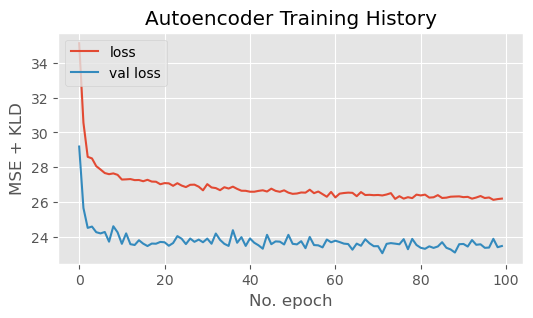

5677/5677 [==============================] - 10s 2ms/step
------------------------ KFold: 4 ---------------------------
The training dataset has 181961 records for the majority class and 315 records for the minority class.
The test dataset has 45490 records for the majority class and 79 records for the minority class.
Number of samples to be generated:  181646
Epoch 1/100
283/283 [==============================] - 2s 4ms/step - loss: 35.1811 - val_loss: 30.5049
Epoch 2/100
283/283 [==============================] - 2s 8ms/step - loss: 30.9395 - val_loss: 27.8797
Epoch 3/100
283/283 [==============================] - 2s 7ms/step - loss: 28.9420 - val_loss: 26.1848
Epoch 4/100
283/283 [==============================] - 2s 6ms/step - loss: 28.2968 - val_loss: 26.1629
Epoch 5/100
283/283 [==============================] - 2s 5ms/step - loss: 27.8246 - val_loss: 25.7959
Epoch 6/100
283/283 [==============================] - 2s 6ms/step - loss: 27.8932 - val_loss: 25.8203
Epoch 7/100
283/283

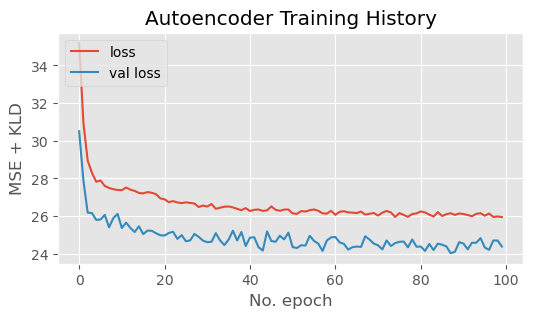

5677/5677 [==============================] - 9s 2ms/step
------------------------ KFold: 5 ---------------------------
The training dataset has 181961 records for the majority class and 315 records for the minority class.
The test dataset has 45490 records for the majority class and 79 records for the minority class.
Number of samples to be generated:  181646
Epoch 1/100
283/283 [==============================] - 2s 4ms/step - loss: 35.0058 - val_loss: 40.6051
Epoch 2/100
283/283 [==============================] - 1s 3ms/step - loss: 30.0498 - val_loss: 37.0854
Epoch 3/100
283/283 [==============================] - 2s 6ms/step - loss: 28.0934 - val_loss: 36.1809
Epoch 4/100
283/283 [==============================] - 2s 7ms/step - loss: 27.2505 - val_loss: 36.3962
Epoch 5/100
283/283 [==============================] - 2s 6ms/step - loss: 27.1156 - val_loss: 35.6374
Epoch 6/100
283/283 [==============================] - 2s 6ms/step - loss: 26.7471 - val_loss: 36.3601
Epoch 7/100
283/283 

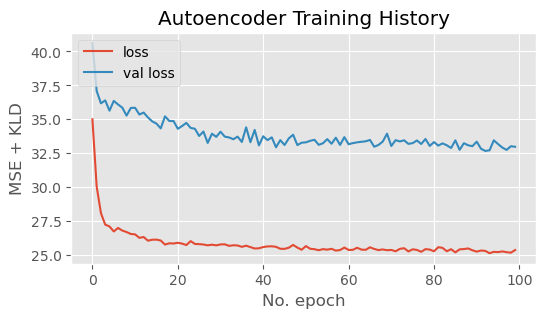

5677/5677 [==============================] - 10s 2ms/step
############################### Parameters tested: {'var_smoothing': 3.1622776601683795e-05} ################################
------------------------ KFold: 1 ---------------------------
The training dataset has 181960 records for the majority class and 316 records for the minority class.
The test dataset has 45491 records for the majority class and 78 records for the minority class.
Number of samples to be generated:  181644
Epoch 1/100
284/284 [==============================] - 3s 5ms/step - loss: 34.8783 - val_loss: 29.0844
Epoch 2/100
284/284 [==============================] - 1s 4ms/step - loss: 29.7583 - val_loss: 26.3748
Epoch 3/100
284/284 [==============================] - 1s 4ms/step - loss: 28.5860 - val_loss: 25.7073
Epoch 4/100
284/284 [==============================] - 1s 4ms/step - loss: 28.1112 - val_loss: 25.2357
Epoch 5/100
284/284 [==============================] - 1s 4ms/step - loss: 27.9410 - val_loss: 25.3

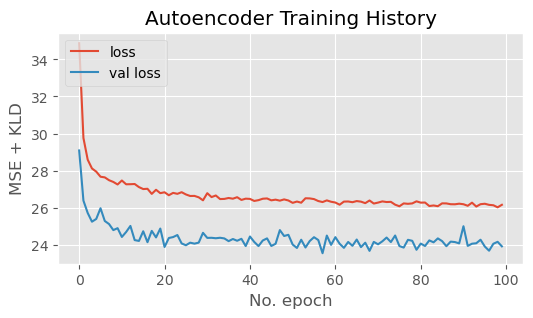

5677/5677 [==============================] - 13s 2ms/step
------------------------ KFold: 2 ---------------------------
The training dataset has 181961 records for the majority class and 315 records for the minority class.
The test dataset has 45490 records for the majority class and 79 records for the minority class.
Number of samples to be generated:  181646
Epoch 1/100
283/283 [==============================] - 3s 5ms/step - loss: 34.3464 - val_loss: 28.4646
Epoch 2/100
283/283 [==============================] - 1s 4ms/step - loss: 29.9445 - val_loss: 25.7123
Epoch 3/100
283/283 [==============================] - 1s 4ms/step - loss: 28.4230 - val_loss: 25.5596
Epoch 4/100
283/283 [==============================] - 1s 5ms/step - loss: 28.0908 - val_loss: 24.9361
Epoch 5/100
283/283 [==============================] - 2s 5ms/step - loss: 28.1205 - val_loss: 25.0358
Epoch 6/100
283/283 [==============================] - 1s 5ms/step - loss: 27.8275 - val_loss: 25.1028
Epoch 7/100
283/283

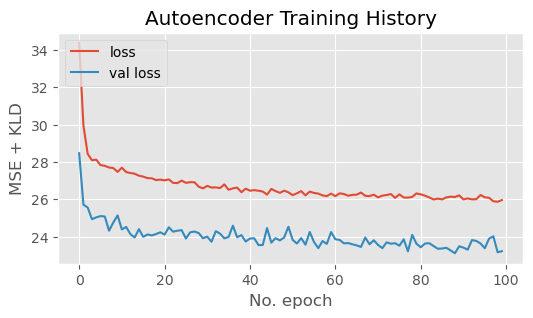

5677/5677 [==============================] - 11s 2ms/step
------------------------ KFold: 3 ---------------------------
The training dataset has 181961 records for the majority class and 315 records for the minority class.
The test dataset has 45490 records for the majority class and 79 records for the minority class.
Number of samples to be generated:  181646
Epoch 1/100
283/283 [==============================] - 2s 5ms/step - loss: 35.3472 - val_loss: 29.1184
Epoch 2/100
283/283 [==============================] - 1s 4ms/step - loss: 30.4491 - val_loss: 25.4592
Epoch 3/100
283/283 [==============================] - 1s 4ms/step - loss: 28.8065 - val_loss: 24.7409
Epoch 4/100
283/283 [==============================] - 1s 4ms/step - loss: 28.9043 - val_loss: 24.6474
Epoch 5/100
283/283 [==============================] - 1s 4ms/step - loss: 28.1280 - val_loss: 24.3525
Epoch 6/100
283/283 [==============================] - 1s 4ms/step - loss: 28.1310 - val_loss: 24.0654
Epoch 7/100
283/283

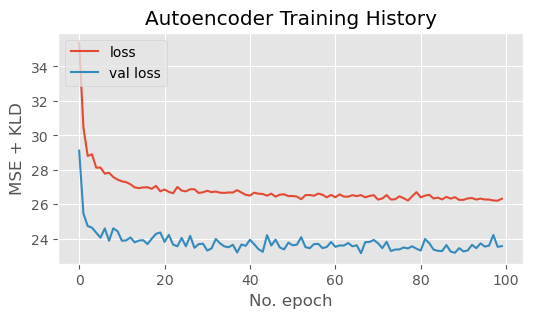

5677/5677 [==============================] - 11s 2ms/step
------------------------ KFold: 4 ---------------------------
The training dataset has 181961 records for the majority class and 315 records for the minority class.
The test dataset has 45490 records for the majority class and 79 records for the minority class.
Number of samples to be generated:  181646
Epoch 1/100
283/283 [==============================] - 3s 7ms/step - loss: 35.1000 - val_loss: 29.6391
Epoch 2/100
283/283 [==============================] - 2s 5ms/step - loss: 29.8336 - val_loss: 26.4951
Epoch 3/100
283/283 [==============================] - 2s 5ms/step - loss: 28.2726 - val_loss: 26.0949
Epoch 4/100
283/283 [==============================] - 1s 5ms/step - loss: 28.0843 - val_loss: 26.1120
Epoch 5/100
283/283 [==============================] - 1s 5ms/step - loss: 27.7440 - val_loss: 25.7782
Epoch 6/100
283/283 [==============================] - 1s 4ms/step - loss: 27.7765 - val_loss: 25.5248
Epoch 7/100
283/283

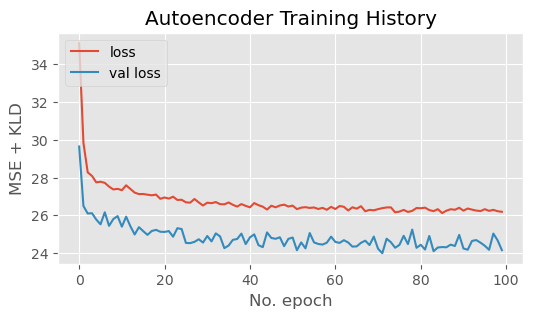

5677/5677 [==============================] - 10s 2ms/step
------------------------ KFold: 5 ---------------------------
The training dataset has 181961 records for the majority class and 315 records for the minority class.
The test dataset has 45490 records for the majority class and 79 records for the minority class.
Number of samples to be generated:  181646
Epoch 1/100
283/283 [==============================] - 3s 7ms/step - loss: 33.9325 - val_loss: 38.6744
Epoch 2/100
283/283 [==============================] - 2s 7ms/step - loss: 28.6890 - val_loss: 36.1677
Epoch 3/100
283/283 [==============================] - 2s 6ms/step - loss: 27.2083 - val_loss: 36.0140
Epoch 4/100
283/283 [==============================] - 2s 6ms/step - loss: 26.8406 - val_loss: 36.3640
Epoch 5/100
283/283 [==============================] - 1s 5ms/step - loss: 26.5864 - val_loss: 35.8492
Epoch 6/100
283/283 [==============================] - 1s 5ms/step - loss: 26.5594 - val_loss: 35.6732
Epoch 7/100
283/283

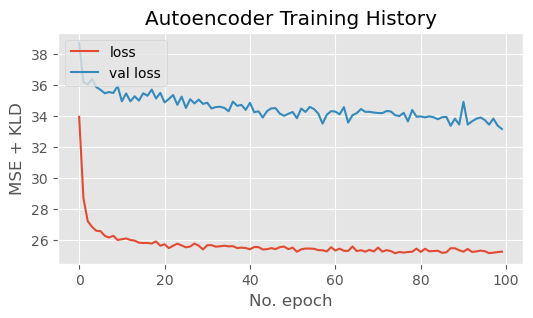

5677/5677 [==============================] - 16s 3ms/step
############################### Parameters tested: {'var_smoothing': 1.7782794100389227e-07} ################################
------------------------ KFold: 1 ---------------------------
The training dataset has 181960 records for the majority class and 316 records for the minority class.
The test dataset has 45491 records for the majority class and 78 records for the minority class.
Number of samples to be generated:  181644
Epoch 1/100
284/284 [==============================] - 2s 4ms/step - loss: 35.3335 - val_loss: 30.0564
Epoch 2/100
284/284 [==============================] - 1s 3ms/step - loss: 30.3014 - val_loss: 26.1283
Epoch 3/100
284/284 [==============================] - 1s 3ms/step - loss: 28.7566 - val_loss: 26.4101
Epoch 4/100
284/284 [==============================] - 1s 3ms/step - loss: 28.3989 - val_loss: 25.8737
Epoch 5/100
284/284 [==============================] - 1s 3ms/step - loss: 27.9906 - val_loss: 25.3

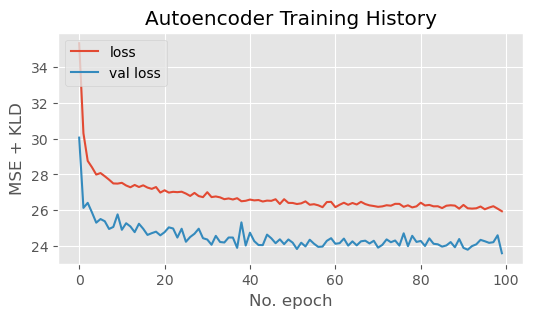

5677/5677 [==============================] - 10s 2ms/step
------------------------ KFold: 2 ---------------------------
The training dataset has 181961 records for the majority class and 315 records for the minority class.
The test dataset has 45490 records for the majority class and 79 records for the minority class.
Number of samples to be generated:  181646
Epoch 1/100
283/283 [==============================] - 3s 5ms/step - loss: 34.7131 - val_loss: 28.9619
Epoch 2/100
283/283 [==============================] - 1s 4ms/step - loss: 30.0708 - val_loss: 25.3736
Epoch 3/100
283/283 [==============================] - 1s 4ms/step - loss: 28.5825 - val_loss: 24.8458
Epoch 4/100
283/283 [==============================] - 1s 4ms/step - loss: 28.2705 - val_loss: 24.9043
Epoch 5/100
283/283 [==============================] - 1s 4ms/step - loss: 28.0128 - val_loss: 24.3158
Epoch 6/100
283/283 [==============================] - 1s 4ms/step - loss: 27.8956 - val_loss: 24.9004
Epoch 7/100
283/283

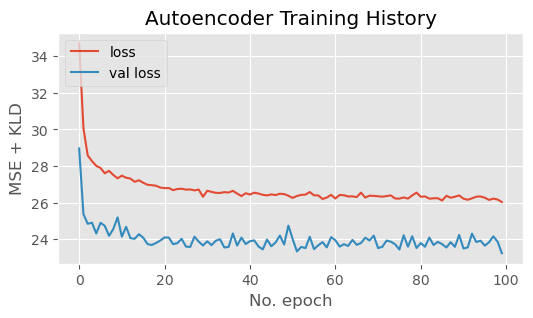

5677/5677 [==============================] - 11s 2ms/step
------------------------ KFold: 3 ---------------------------
The training dataset has 181961 records for the majority class and 315 records for the minority class.
The test dataset has 45490 records for the majority class and 79 records for the minority class.
Number of samples to be generated:  181646
Epoch 1/100
283/283 [==============================] - 2s 4ms/step - loss: 34.9453 - val_loss: 28.2109
Epoch 2/100
283/283 [==============================] - 2s 7ms/step - loss: 30.0713 - val_loss: 25.3314
Epoch 3/100
283/283 [==============================] - 2s 8ms/step - loss: 28.4291 - val_loss: 24.7569
Epoch 4/100
283/283 [==============================] - 2s 7ms/step - loss: 28.1856 - val_loss: 24.3442
Epoch 5/100
283/283 [==============================] - 2s 7ms/step - loss: 28.1947 - val_loss: 24.0290
Epoch 6/100
283/283 [==============================] - 2s 5ms/step - loss: 27.7728 - val_loss: 24.1315
Epoch 7/100
283/283

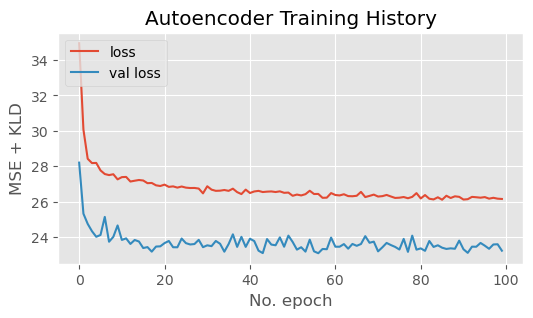

5677/5677 [==============================] - 12s 2ms/step
------------------------ KFold: 4 ---------------------------
The training dataset has 181961 records for the majority class and 315 records for the minority class.
The test dataset has 45490 records for the majority class and 79 records for the minority class.
Number of samples to be generated:  181646
Epoch 1/100
283/283 [==============================] - 3s 7ms/step - loss: 34.3007 - val_loss: 29.5316
Epoch 2/100
283/283 [==============================] - 1s 5ms/step - loss: 29.8743 - val_loss: 26.4169
Epoch 3/100
283/283 [==============================] - 1s 5ms/step - loss: 28.4835 - val_loss: 25.9667
Epoch 4/100
283/283 [==============================] - 1s 4ms/step - loss: 28.3759 - val_loss: 26.1694
Epoch 5/100
283/283 [==============================] - 1s 4ms/step - loss: 27.8496 - val_loss: 25.6321
Epoch 6/100
283/283 [==============================] - 1s 4ms/step - loss: 27.9355 - val_loss: 25.8489
Epoch 7/100
283/283

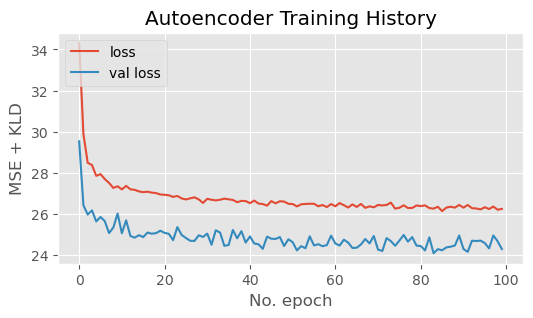

5677/5677 [==============================] - 10s 2ms/step
------------------------ KFold: 5 ---------------------------
The training dataset has 181961 records for the majority class and 315 records for the minority class.
The test dataset has 45490 records for the majority class and 79 records for the minority class.
Number of samples to be generated:  181646
Epoch 1/100
283/283 [==============================] - 3s 5ms/step - loss: 33.6413 - val_loss: 38.5976
Epoch 2/100
283/283 [==============================] - 3s 12ms/step - loss: 28.8633 - val_loss: 35.8503
Epoch 3/100
283/283 [==============================] - 3s 9ms/step - loss: 27.5343 - val_loss: 35.9811
Epoch 4/100
283/283 [==============================] - 2s 8ms/step - loss: 26.9732 - val_loss: 36.0916
Epoch 5/100
283/283 [==============================] - 1s 5ms/step - loss: 26.8610 - val_loss: 35.5489
Epoch 6/100
283/283 [==============================] - 1s 5ms/step - loss: 26.6334 - val_loss: 36.0537
Epoch 7/100
283/28

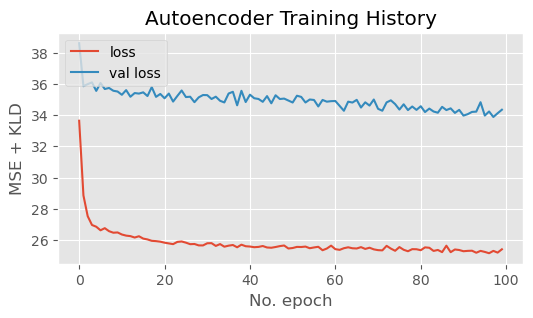

5677/5677 [==============================] - 17s 3ms/step
############################### Parameters tested: {'var_smoothing': 1e-09} ################################
------------------------ KFold: 1 ---------------------------
The training dataset has 181960 records for the majority class and 316 records for the minority class.
The test dataset has 45491 records for the majority class and 78 records for the minority class.
Number of samples to be generated:  181644
Epoch 1/100
284/284 [==============================] - 4s 7ms/step - loss: 34.9467 - val_loss: 29.2067
Epoch 2/100
284/284 [==============================] - 1s 5ms/step - loss: 29.8672 - val_loss: 26.1718
Epoch 3/100
284/284 [==============================] - 1s 5ms/step - loss: 28.4492 - val_loss: 25.6511
Epoch 4/100
284/284 [==============================] - 1s 5ms/step - loss: 28.2005 - val_loss: 25.3584
Epoch 5/100
284/284 [==============================] - 1s 5ms/step - loss: 28.1355 - val_loss: 25.5779
Epoch 6/100
2

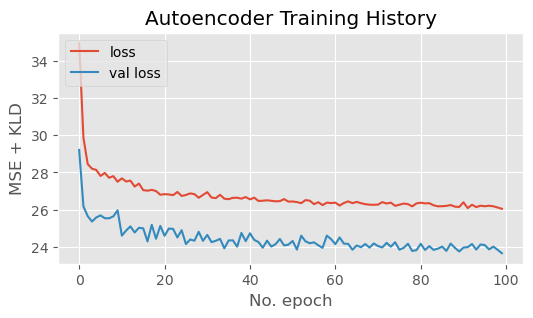

5677/5677 [==============================] - 17s 3ms/step
------------------------ KFold: 2 ---------------------------
The training dataset has 181961 records for the majority class and 315 records for the minority class.
The test dataset has 45490 records for the majority class and 79 records for the minority class.
Number of samples to be generated:  181646
Epoch 1/100
283/283 [==============================] - 4s 7ms/step - loss: 34.9245 - val_loss: 29.2508
Epoch 2/100
283/283 [==============================] - 1s 5ms/step - loss: 30.3379 - val_loss: 25.6651
Epoch 3/100
283/283 [==============================] - 1s 5ms/step - loss: 28.7419 - val_loss: 24.9795
Epoch 4/100
283/283 [==============================] - 2s 5ms/step - loss: 28.4961 - val_loss: 25.2774
Epoch 5/100
283/283 [==============================] - 1s 5ms/step - loss: 28.1122 - val_loss: 24.4764
Epoch 6/100
283/283 [==============================] - 2s 5ms/step - loss: 27.9652 - val_loss: 24.9564
Epoch 7/100
283/283

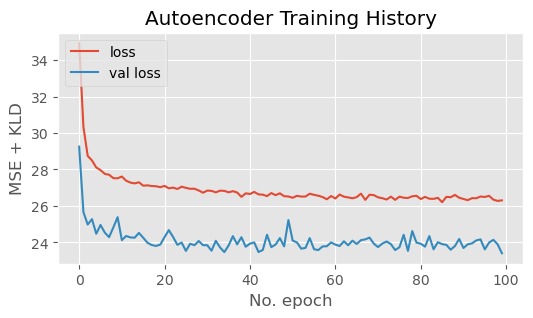

5677/5677 [==============================] - 16s 3ms/step
------------------------ KFold: 3 ---------------------------
The training dataset has 181961 records for the majority class and 315 records for the minority class.
The test dataset has 45490 records for the majority class and 79 records for the minority class.
Number of samples to be generated:  181646
Epoch 1/100
283/283 [==============================] - 4s 7ms/step - loss: 34.4966 - val_loss: 27.2153
Epoch 2/100
283/283 [==============================] - 1s 5ms/step - loss: 29.9930 - val_loss: 25.1884
Epoch 3/100
283/283 [==============================] - 1s 5ms/step - loss: 28.6871 - val_loss: 24.8474
Epoch 4/100
283/283 [==============================] - 2s 7ms/step - loss: 28.1843 - val_loss: 24.3231
Epoch 5/100
283/283 [==============================] - 1s 5ms/step - loss: 28.2026 - val_loss: 24.4383
Epoch 6/100
283/283 [==============================] - 1s 5ms/step - loss: 27.8759 - val_loss: 24.0283
Epoch 7/100
283/283

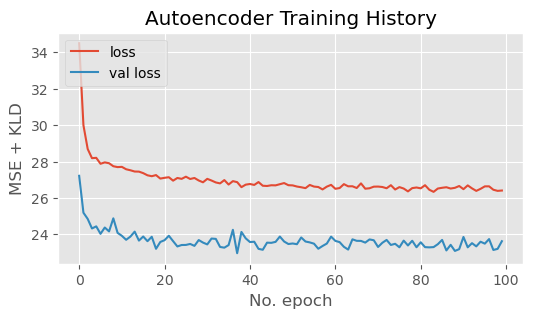

5677/5677 [==============================] - 16s 3ms/step
------------------------ KFold: 4 ---------------------------
The training dataset has 181961 records for the majority class and 315 records for the minority class.
The test dataset has 45490 records for the majority class and 79 records for the minority class.
Number of samples to be generated:  181646
Epoch 1/100
283/283 [==============================] - 5s 8ms/step - loss: 35.1431 - val_loss: 29.6459
Epoch 2/100
283/283 [==============================] - 1s 5ms/step - loss: 29.7943 - val_loss: 26.6062
Epoch 3/100
283/283 [==============================] - 1s 5ms/step - loss: 28.2469 - val_loss: 26.0637
Epoch 4/100
283/283 [==============================] - 1s 5ms/step - loss: 28.0723 - val_loss: 25.9263
Epoch 5/100
283/283 [==============================] - 1s 5ms/step - loss: 27.7756 - val_loss: 25.7776
Epoch 6/100
283/283 [==============================] - 1s 5ms/step - loss: 27.7792 - val_loss: 25.4951
Epoch 7/100
283/283

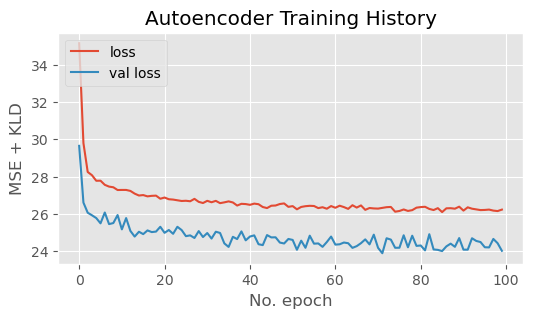

5677/5677 [==============================] - 17s 3ms/step
------------------------ KFold: 5 ---------------------------
The training dataset has 181961 records for the majority class and 315 records for the minority class.
The test dataset has 45490 records for the majority class and 79 records for the minority class.
Number of samples to be generated:  181646
Epoch 1/100
283/283 [==============================] - 4s 7ms/step - loss: 34.5304 - val_loss: 39.0198
Epoch 2/100
283/283 [==============================] - 1s 5ms/step - loss: 29.6712 - val_loss: 36.4543
Epoch 3/100
283/283 [==============================] - 1s 5ms/step - loss: 27.5890 - val_loss: 36.1376
Epoch 4/100
283/283 [==============================] - 1s 5ms/step - loss: 27.0950 - val_loss: 36.0274
Epoch 5/100
283/283 [==============================] - 1s 5ms/step - loss: 26.8754 - val_loss: 35.7785
Epoch 6/100
283/283 [==============================] - 1s 5ms/step - loss: 26.7073 - val_loss: 36.1692
Epoch 7/100
283/283

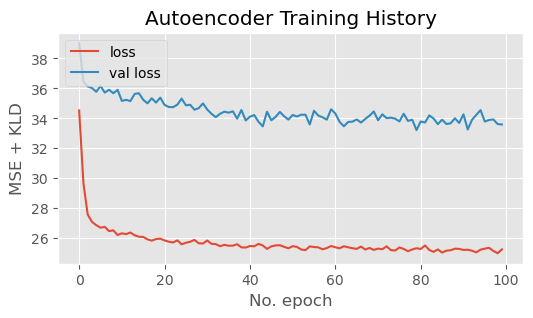

5677/5677 [==============================] - 17s 3ms/step
Accuracy:, 0.999087 (+/- 0.000053)
Precision: 0.753123 (+/- 0.009064)
Recall: 0.702824 (+/- 0.055000)
F1 score: 0.725803 (+/- 0.028379)
ROC_AUC: 0.851212 (+/- 0.027479)
Best hyperparameters: {'var_smoothing': 1.0}


In [23]:
#With hyperparameter tuning
#Cross validation
skf = StratifiedKFold(n_splits=5)

# Define the hyperparameters to tune
param_grid = {
    'var_smoothing': np.logspace(0,-9, num=5)
}


# Initialize variables to store the best hyperparameters and AUC score
best_params = {}
best_scores = []
best_f1 = -np.inf

# Iterate over all combinations of hyperparameters
for params in ParameterGrid(param_grid):
    lst_accuracy = []
    lst_precision = []
    lst_recall = []
    lst_f1_score = []
    lst_roc_auc_score = []
    
    f1_scores = []

    model = GaussianNB(var_smoothing=params['var_smoothing'])

    print("############################### Parameters tested:", params,"################################")
    for count, (train_index, valid_index) in enumerate(skf.split(X_train, y_train)):
        print("------------------------ KFold:", count+1, "---------------------------")
        X_train_fold, X_valid_fold = X_train.iloc[train_index], X_train.iloc[valid_index]
        y_train_fold, y_valid_fold = y_train.iloc[train_index], y_train.iloc[valid_index]

        print(f"The training dataset has {sorted(Counter(y_train_fold).items())[0][1]} records for the majority class and {sorted(Counter(y_train_fold).items())[1][1]} records for the minority class.")
        print(f"The test dataset has {sorted(Counter(y_valid_fold).items())[0][1]} records for the majority class and {sorted(Counter(y_valid_fold).items())[1][1]} records for the minority class.")
        
        maj = len(y_train_fold[y_train_fold == 0])
        mino = len(y_train_fold[y_train_fold == 1])
        frac = 0.5
        num_samples = round(1/(1/frac - 1) * maj - mino)

        print("Number of samples to be generated: ", num_samples)

        # Variational Oversampling 
        vos = VAE_oversampling(hidden_dim= 64,
                                latent_dim=2,
                                original_dim=30,
                                minority_class_id=1,
                                epochs=100,
                                batch_size=1,
                                num_samples_to_generate = num_samples,
                                random_state = 0,
                                optimizer="adam")

        #Fit the VAE oversampling model and get new data set
        X_res_val,y_res_val = vos.fit_sample(X_train_fold,y_train_fold)
        
        std = StandardScaler()

        X_train_processed = std.fit_transform(X_res_val) 
        X_valid_processed = std.transform(X_valid_fold)

        model.fit(X_train_processed, y_res_val)

        y_pred_test = model.predict(X_valid_processed)

        lst_accuracy.append(accuracy_score(y_valid_fold, y_pred_test))
        lst_precision.append(precision_score(y_valid_fold, y_pred_test))
        lst_recall.append(recall_score(y_valid_fold, y_pred_test))
        lst_f1_score.append(f1_score(y_valid_fold, y_pred_test))
        lst_roc_auc_score.append(roc_auc_score(y_valid_fold, y_pred_test))


    avg_f1 = np.mean(lst_f1_score)

    if avg_f1 > best_f1:
        best_f1 = avg_f1
        best_scores = [lst_accuracy, lst_precision, lst_recall, lst_f1_score, lst_roc_auc_score]
        best_params = params

# Print the best AUC score and hyperparameters
print(f"Accuracy:, {np.mean(best_scores[0]):0.6f} (+/- {np.std(best_scores[0]):0.6f})")
print(f"Precision: {np.mean(best_scores[1]):0.6f} (+/- {np.std(best_scores[1]):0.6f})")
print(f"Recall: {np.mean(best_scores[2]):0.6f} (+/- {np.std(best_scores[2]):0.6f})")
print(f"F1 score: {np.mean(best_scores[3]):0.6f} (+/- {np.std(best_scores[3]):0.6f})")
print(f"ROC_AUC: {np.mean(best_scores[4]):0.6f} (+/- {np.std(best_scores[4]):0.6f})")
print("Best hyperparameters:", best_params)


### Cross Validation

------------------------ KFold: 1 ---------------------------
The training dataset has 181960 records for the majority class and 316 records for the minority class.
The test dataset has 45491 records for the majority class and 78 records for the minority class.
NUmber of samples to be generated:  181644
Epoch 1/100
284/284 [==============================] - 2s 5ms/step - loss: 35.5325 - val_loss: 30.4985
Epoch 2/100
284/284 [==============================] - 1s 4ms/step - loss: 30.7902 - val_loss: 26.3365
Epoch 3/100
284/284 [==============================] - 1s 4ms/step - loss: 28.7932 - val_loss: 25.4404
Epoch 4/100
284/284 [==============================] - 1s 4ms/step - loss: 28.1981 - val_loss: 25.6052
Epoch 5/100
284/284 [==============================] - 1s 4ms/step - loss: 27.8985 - val_loss: 25.4119
Epoch 6/100
284/284 [==============================] - 1s 3ms/step - loss: 27.8465 - val_loss: 25.2575
Epoch 7/100
284/284 [==============================] - 1s 3ms/step - loss: 27

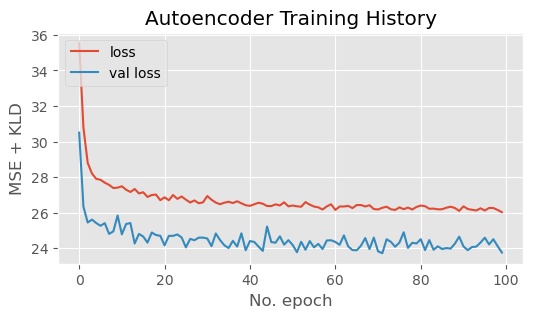

5677/5677 [==============================] - 9s 2ms/step
------------------------ KFold: 2 ---------------------------
The training dataset has 181961 records for the majority class and 315 records for the minority class.
The test dataset has 45490 records for the majority class and 79 records for the minority class.
NUmber of samples to be generated:  181646
Epoch 1/100
283/283 [==============================] - 2s 5ms/step - loss: 34.2501 - val_loss: 27.5718
Epoch 2/100
283/283 [==============================] - 1s 4ms/step - loss: 29.6881 - val_loss: 25.3521
Epoch 3/100
283/283 [==============================] - 1s 4ms/step - loss: 28.4936 - val_loss: 25.0213
Epoch 4/100
283/283 [==============================] - 1s 4ms/step - loss: 28.1373 - val_loss: 24.8395
Epoch 5/100
283/283 [==============================] - 1s 3ms/step - loss: 28.2788 - val_loss: 24.8588
Epoch 6/100
283/283 [==============================] - 1s 3ms/step - loss: 27.9614 - val_loss: 24.7241
Epoch 7/100
283/283 

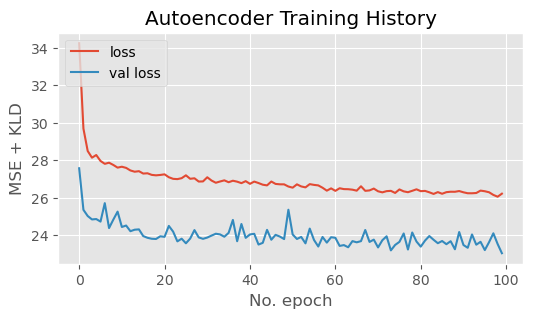

5677/5677 [==============================] - 9s 2ms/step
------------------------ KFold: 3 ---------------------------
The training dataset has 181961 records for the majority class and 315 records for the minority class.
The test dataset has 45490 records for the majority class and 79 records for the minority class.
NUmber of samples to be generated:  181646
Epoch 1/100
283/283 [==============================] - 2s 5ms/step - loss: 35.0802 - val_loss: 28.2591
Epoch 2/100
283/283 [==============================] - 1s 4ms/step - loss: 29.9436 - val_loss: 25.1717
Epoch 3/100
283/283 [==============================] - 1s 4ms/step - loss: 28.6594 - val_loss: 24.5874
Epoch 4/100
283/283 [==============================] - 1s 4ms/step - loss: 28.6883 - val_loss: 24.6497
Epoch 5/100
283/283 [==============================] - 1s 4ms/step - loss: 28.0993 - val_loss: 24.5858
Epoch 6/100
283/283 [==============================] - 1s 4ms/step - loss: 28.0954 - val_loss: 24.1449
Epoch 7/100
283/283 

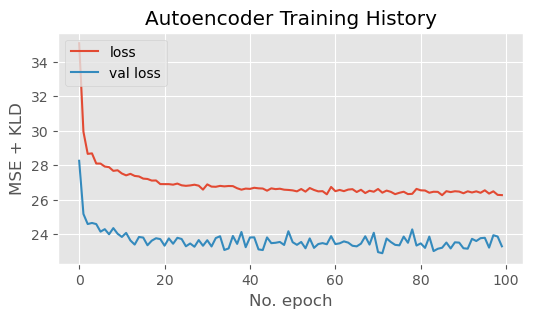

5677/5677 [==============================] - 9s 2ms/step
------------------------ KFold: 4 ---------------------------
The training dataset has 181961 records for the majority class and 315 records for the minority class.
The test dataset has 45490 records for the majority class and 79 records for the minority class.
NUmber of samples to be generated:  181646
Epoch 1/100
283/283 [==============================] - 3s 7ms/step - loss: 35.4831 - val_loss: 30.5819
Epoch 2/100
283/283 [==============================] - 1s 4ms/step - loss: 30.3774 - val_loss: 27.0215
Epoch 3/100
283/283 [==============================] - 1s 4ms/step - loss: 28.4309 - val_loss: 25.9801
Epoch 4/100
283/283 [==============================] - 1s 4ms/step - loss: 28.0496 - val_loss: 26.0550
Epoch 5/100
283/283 [==============================] - 1s 3ms/step - loss: 27.8219 - val_loss: 25.7936
Epoch 6/100
283/283 [==============================] - 1s 3ms/step - loss: 27.8197 - val_loss: 25.6371
Epoch 7/100
283/283 

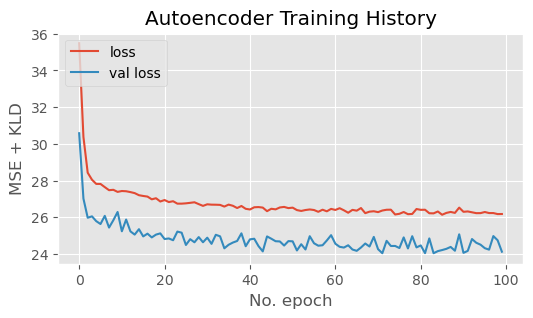

5677/5677 [==============================] - 10s 2ms/step
------------------------ KFold: 5 ---------------------------
The training dataset has 181961 records for the majority class and 315 records for the minority class.
The test dataset has 45490 records for the majority class and 79 records for the minority class.
NUmber of samples to be generated:  181646
Epoch 1/100
283/283 [==============================] - 3s 6ms/step - loss: 33.9913 - val_loss: 39.0932
Epoch 2/100
283/283 [==============================] - 1s 5ms/step - loss: 29.1880 - val_loss: 36.2668
Epoch 3/100
283/283 [==============================] - 1s 5ms/step - loss: 27.2349 - val_loss: 35.9018
Epoch 4/100
283/283 [==============================] - 1s 5ms/step - loss: 27.0357 - val_loss: 35.9200
Epoch 5/100
283/283 [==============================] - 1s 5ms/step - loss: 26.6032 - val_loss: 35.6793
Epoch 6/100
283/283 [==============================] - 1s 4ms/step - loss: 26.6442 - val_loss: 36.0847
Epoch 7/100
283/283

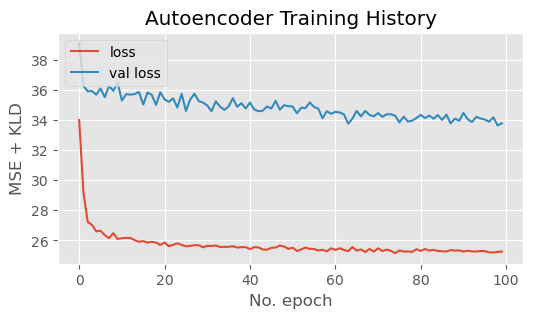

5677/5677 [==============================] - 12s 2ms/step


In [11]:
#Cross validation
skf = StratifiedKFold(n_splits=5)
lst_accuracy = []
lst_precision = []
lst_recall = []
lst_f1_score = []
lst_roc_auc_score = []

model = GaussianNB()

for count, (train_index, valid_index) in enumerate(skf.split(X_train, y_train)):
    print("------------------------ KFold:", count+1, "---------------------------")
    X_train_fold, X_valid_fold = X_train.iloc[train_index], X_train.iloc[valid_index]
    y_train_fold, y_valid_fold = y_train.iloc[train_index], y_train.iloc[valid_index]

    print(f"The training dataset has {sorted(Counter(y_train_fold).items())[0][1]} records for the majority class and {sorted(Counter(y_train_fold).items())[1][1]} records for the minority class.")
    print(f"The test dataset has {sorted(Counter(y_valid_fold).items())[0][1]} records for the majority class and {sorted(Counter(y_valid_fold).items())[1][1]} records for the minority class.")
    
    maj = len(y_train_fold[y_train_fold == 0])
    mino = len(y_train_fold[y_train_fold == 1])
    frac = 0.5
    num_samples = round(1/(1/frac - 1) * maj - mino)

    print("NUmber of samples to be generated: ", num_samples)

    # Variational Oversampling 
    vos = VAE_oversampling(hidden_dim= 64,
                            latent_dim=2,
                            original_dim=30,
                            minority_class_id=1,
                            epochs=100,
                            batch_size=1,
                            num_samples_to_generate = num_samples,
                            random_state = 0,
                            optimizer="adam")

    #Fit the VAE oversampling model and get new data set
    X_res_val,y_res_val = vos.fit_sample(X_train_fold,y_train_fold)
    
    std = StandardScaler()
    
    X_train_processed = std.fit_transform(X_res_val) 
    X_valid_processed = std.transform(X_valid_fold)

    model.fit(X_train_processed, y_res_val)

    y_pred_test = model.predict(X_valid_processed)

    lst_accuracy.append(accuracy_score(y_valid_fold, y_pred_test))
    lst_precision.append(precision_score(y_valid_fold, y_pred_test))
    lst_recall.append(recall_score(y_valid_fold, y_pred_test))
    lst_f1_score.append(f1_score(y_valid_fold, y_pred_test))
    lst_roc_auc_score.append(roc_auc_score(y_valid_fold, y_pred_test))


In [12]:
print(f"Accuracy:, {np.mean(lst_accuracy):0.6f} (+/- {np.std(lst_accuracy):0.6f})")
print(f"Precision: {np.mean(lst_precision):0.6f} (+/- {np.std(lst_precision):0.6f})")
print(f"Recall: {np.mean(lst_recall):0.6f} (+/- {np.std(lst_recall):0.6f})")
print(f"F1 score: {np.mean(lst_f1_score):0.6f} (+/- {np.std(lst_f1_score):0.6f})")
print(f"ROC_AUC: {np.mean(lst_roc_auc_score):0.6f} (+/- {np.std(lst_roc_auc_score):0.6f})")

Accuracy:, 0.999320 (+/- 0.000037)
Precision: 0.907407 (+/- 0.024414)
Recall: 0.677540 (+/- 0.046677)
F1 score: 0.774122 (+/- 0.021171)
ROC_AUC: 0.838708 (+/- 0.023317)


### One fit

Epoch 1/100
354/354 [==============================] - 2s 4ms/step - loss: 33.6678 - val_loss: 25.8653
Epoch 2/100
354/354 [==============================] - 1s 3ms/step - loss: 29.3683 - val_loss: 23.9919
Epoch 3/100
354/354 [==============================] - 1s 3ms/step - loss: 28.5344 - val_loss: 23.9801
Epoch 4/100
354/354 [==============================] - 1s 3ms/step - loss: 28.2976 - val_loss: 23.3475
Epoch 5/100
354/354 [==============================] - 1s 3ms/step - loss: 27.8588 - val_loss: 23.4060
Epoch 6/100
354/354 [==============================] - 1s 3ms/step - loss: 27.8176 - val_loss: 23.5880
Epoch 7/100
354/354 [==============================] - 1s 3ms/step - loss: 27.8209 - val_loss: 23.7741
Epoch 8/100
354/354 [==============================] - 1s 3ms/step - loss: 27.6769 - val_loss: 23.8379
Epoch 9/100
354/354 [==============================] - 1s 3ms/step - loss: 27.5351 - val_loss: 23.1233
Epoch 10/100
354/354 [==============================] - 1s 3ms/step - los

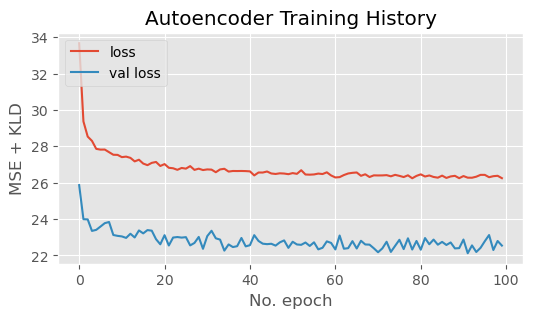

7096/7096 [==============================] - 12s 2ms/step


In [8]:
maj = len(y_train[y_train == 0])
mino = len(y_train[y_train == 1])
frac = 0.5
num_samples = round(1/(1/frac - 1) * maj - mino)

# Variational Oversampling 
vos = VAE_oversampling(hidden_dim= 64,
                        latent_dim=2,
                        original_dim=30,
                        minority_class_id=1,
                        epochs=100,
                        batch_size=1,
                        num_samples_to_generate = num_samples,
                        random_state = 0,
                        optimizer="adam")

#Fit the VAE oversampling model and get new data set
X_res_val,y_res_val = vos.fit_sample(X_train,y_train)

std = StandardScaler()

X_train_processed = std.fit_transform(X_res_val) 
X_test_processed = std.transform(X_test)

In [9]:
pd.DataFrame(X_res_val)

0         1         2         3         4         5   \
0       161919.000000  1.946747 -0.752526 -1.355130 -0.661630  1.502822   
1       124477.000000  2.035149 -0.048880 -3.058693  0.247945  2.943487   
2        41191.000000 -0.991920  0.603193  0.711976 -0.992425 -0.825838   
3       132624.000000  2.285718 -1.500239 -0.747565 -1.668119 -1.394143   
4        59359.000000 -0.448747 -1.011440  0.115903 -3.454854  0.715771   
...               ...       ...       ...       ...       ...       ...   
454897   83159.195312 -2.033702  3.589421 -2.945578  4.593170 -1.849406   
454898   82832.179688 -4.707807  7.889394 -7.068378  7.471152 -3.101629   
454899   82832.179688 -4.707792  7.892416 -7.068378  7.472758 -3.101606   
454900  110577.187500 -1.262899  3.588769 -3.635028  4.599038  0.450555   
454901  126735.679688 -0.135733  3.588730 -1.962602  4.593683  1.851425   

              6         7         8         9   ...        20        21  \
0       4.024933 -1.479661  1.139880  1.406819  ... -0.134435  0.076197   
1       3.298697 -0.002192  0.674782  0.045826  ... -0.227279  0.038628   
2       1.956261 -2.212603 -5.037523  0.000772  ...  1.280856 -2.798352   
3      -0.350339 -1.427984  0.010010 -1.118447  ... -0.490642 -0.139670   
4      -0.147490  0.504347 -0.113817 -0.044782  ... -0.275297 -0.243245   
...          ...       ...       ...       ...  ...       ...       ...   
454897 -0.684984 -1.747113  0.588279 -1.275228  ...  0.358018  0.641341   
454898 -1.387192 -5.539909  2.738250 -2.589654  ...  0.817842  0.725899   
454899 -1.387192 -5.539909  0.588240 -2.589654  ...  1.736693  0.628824   
454900 -1.372181 -2.607490  0.593148 -1.750241  ...  0.358576  0.628815   
454901 -1.247727 -0.834143  0.587994 -0.554440  ...  0.358077  0.628814   

              22        23        24        25        26        27        28  \
0       0.297537  0.307915  0.690980 -0.350316 -0.388907  0.077641 -0.032248   
1       0.228197  0.035542  0.707090  0.512885 -0.471198  0.002520 -0.069002   
2       0.109526 -0.436530 -0.932803  0.826684  0.913773  0.038049  0.185340   
3       0.077013  0.208310 -0.538236 -0.278032 -0.162068  0.018045 -0.063005   
4      -0.173298 -0.006692 -1.362383 -0.292234 -0.144622 -0.032580 -0.064194   
...          ...       ...       ...       ...       ...       ...       ...   
454897  0.051318 -0.060161 -0.109107  0.019606  0.047838  0.170788  0.096198   
454898  0.818772 -0.062790  0.350466  0.019602  0.048682  0.159445  0.077217   
454899  1.496653 -0.062790 -0.108610  0.034316  0.495890  0.995804  0.077212   
454900  0.051318 -0.062790 -0.109108  0.041252  0.074842  0.198015  0.077395   
454901  0.051318 -0.062790 -0.109108  0.033660  0.049057  0.157064  0.077213   

                29  
0         7.320000  
1         2.990000  
2       175.100000  
3         6.100000  
4        86.100000  
...            ...  
454897  267.514893  
454898  125.591469  
454899  125.591469  
454900  125.592743  
454901  125.591492  

[454902 rows x 30 columns]

In [10]:
nb_vae = GaussianNB()

nb_vae.fit(X_train_processed, y_res_val)

#predict
pred_lr_vae_val = nb_vae.predict(X_test_processed)

model_scores(y_test, pred_lr_vae_val)

Accuracy: 0.9993504441557529
Precision: 0.8961038961038961
Recall: 0.7040816326530612
F1 score: 0.7885714285714286
ROC_AUC: 0.8519704730513478


## Data Augmentation with GAN

### Hyperparameter Tuning

############################### Parameters tested: {'var_smoothing': 1.0} ################################
------------------------ KFold: 1 ---------------------------
The training dataset has 181960 records for the majority class and 316 records for the minority class.
The test dataset has 45491 records for the majority class and 78 records for the minority class.
Number of samples to be generated:  181644
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 20)                620       
                                                                 
 dropout (Dropout)           (None, 20)                0         
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 20)                0         
                                                                 
 dense_1 (Dense)             (None, 10) 

1/1 [==============================] - 2s 2s/step
1 [D loss: 1.094581, acc.: 58.33%] [G loss: 4.087461]
1/1 [==============================] - 1s 1s/step
2 [D loss: 1.011609, acc.: 72.92%] [G loss: 4.000199]
1/1 [==============================] - 1s 1s/step
3 [D loss: 1.052069, acc.: 60.42%] [G loss: 4.232926]
1/1 [==============================] - 1s 1s/step
4 [D loss: 1.068385, acc.: 58.33%] [G loss: 4.047215]
1/1 [==============================] - 0s 493ms/step
5 [D loss: 1.032728, acc.: 62.50%] [G loss: 4.443569]
1/1 [==============================] - 1s 585ms/step
6 [D loss: 1.026164, acc.: 54.17%] [G loss: 4.239409]
1/1 [==============================] - 1s 773ms/step
7 [D loss: 1.067907, acc.: 56.25%] [G loss: 4.293879]
1/1 [==============================] - 1s 699ms/step
8 [D loss: 1.161069, acc.: 52.08%] [G loss: 4.370230]
1/1 [==============================] - 1s 726ms/step
9 [D loss: 1.024176, acc.: 60.42%] [G loss: 4.633562]
1/1 [==============================] - 1s 659ms/s

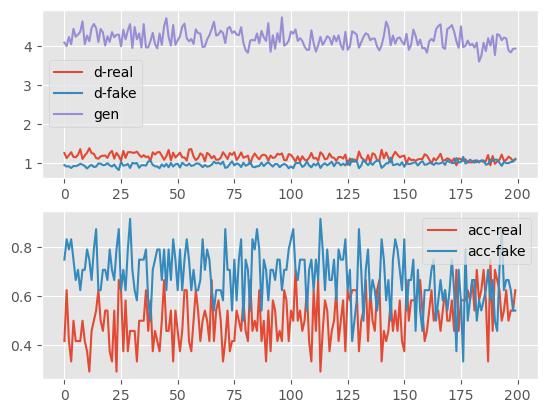

5677/5677 [==============================] - 3675s 647ms/step
------------------------ KFold: 2 ---------------------------
The training dataset has 181961 records for the majority class and 315 records for the minority class.
The test dataset has 45490 records for the majority class and 79 records for the minority class.
Number of samples to be generated:  181646
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 20)                620       
                                                                 
 dropout_4 (Dropout)         (None, 20)                0         
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 20)                0         
                                                                 
 dense_7 (Dense)             (None, 10)                210       
                 

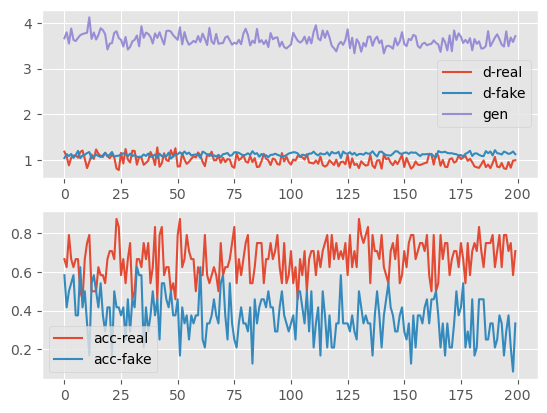

5677/5677 [==============================] - 3249s 572ms/step
------------------------ KFold: 3 ---------------------------
The training dataset has 181961 records for the majority class and 315 records for the minority class.
The test dataset has 45490 records for the majority class and 79 records for the minority class.
Number of samples to be generated:  181646
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 20)                620       
                                                                 
 dropout_8 (Dropout)         (None, 20)                0         
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 20)                0         
                                                                 
 dense_13 (Dense)            (None, 10)                210       
                 

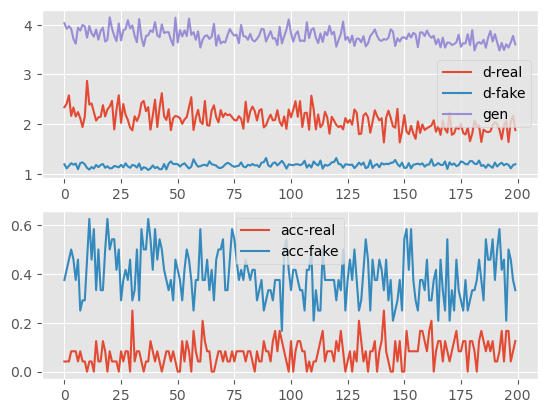

5677/5677 [==============================] - 3470s 611ms/step
------------------------ KFold: 4 ---------------------------
The training dataset has 181961 records for the majority class and 315 records for the minority class.
The test dataset has 45490 records for the majority class and 79 records for the minority class.
Number of samples to be generated:  181646
Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_18 (Dense)            (None, 20)                620       
                                                                 
 dropout_12 (Dropout)        (None, 20)                0         
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 20)                0         
                                                                 
 dense_19 (Dense)            (None, 10)                210       
                 

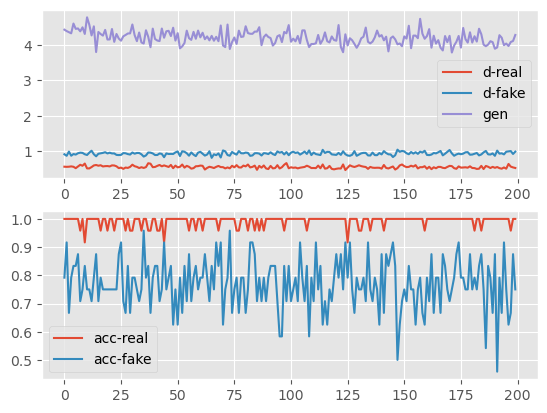

5677/5677 [==============================] - 3302s 582ms/step
------------------------ KFold: 5 ---------------------------
The training dataset has 181961 records for the majority class and 315 records for the minority class.
The test dataset has 45490 records for the majority class and 79 records for the minority class.
Number of samples to be generated:  181646
Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_24 (Dense)            (None, 20)                620       
                                                                 
 dropout_16 (Dropout)        (None, 20)                0         
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 20)                0         
                                                                 
 dense_25 (Dense)            (None, 10)                210       
                

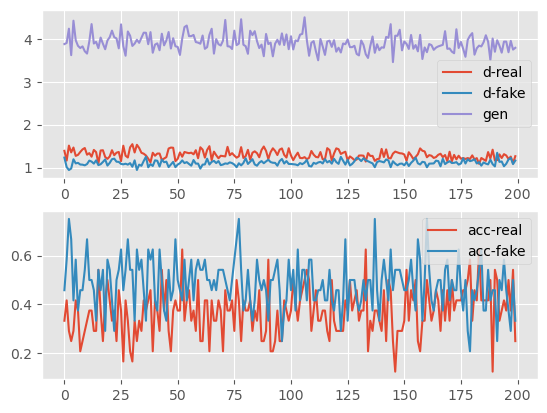

5677/5677 [==============================] - 2189s 386ms/step
############################### Parameters tested: {'var_smoothing': 0.005623413251903491} ################################
------------------------ KFold: 1 ---------------------------
The training dataset has 181960 records for the majority class and 316 records for the minority class.
The test dataset has 45491 records for the majority class and 78 records for the minority class.
Number of samples to be generated:  181644
Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_30 (Dense)            (None, 20)                620       
                                                                 
 dropout_20 (Dropout)        (None, 20)                0         
                                                                 
 leaky_re_lu_10 (LeakyReLU)  (None, 20)                0         
                        

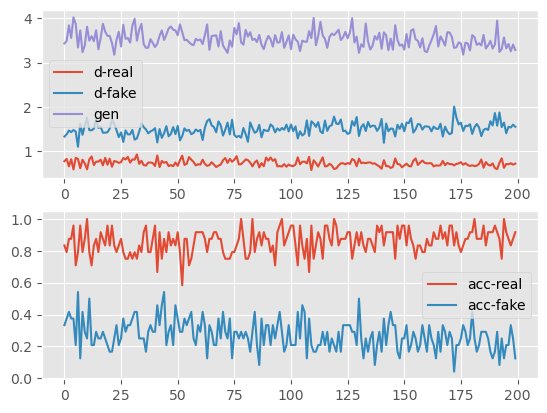

5677/5677 [==============================] - 164s 29ms/step
------------------------ KFold: 2 ---------------------------
The training dataset has 181961 records for the majority class and 315 records for the minority class.
The test dataset has 45490 records for the majority class and 79 records for the minority class.
Number of samples to be generated:  181646
Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_36 (Dense)            (None, 20)                620       
                                                                 
 dropout_24 (Dropout)        (None, 20)                0         
                                                                 
 leaky_re_lu_12 (LeakyReLU)  (None, 20)                0         
                                                                 
 dense_37 (Dense)            (None, 10)                210       
                  

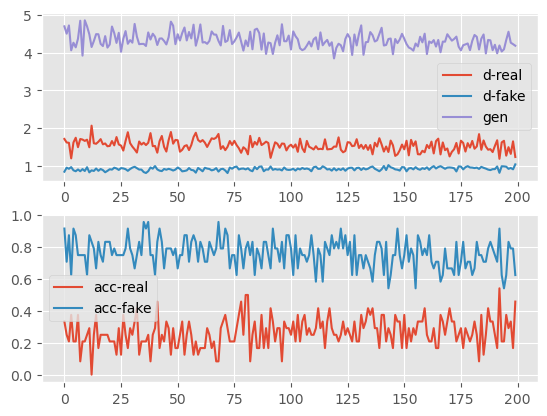

5677/5677 [==============================] - 173s 30ms/step
------------------------ KFold: 3 ---------------------------
The training dataset has 181961 records for the majority class and 315 records for the minority class.
The test dataset has 45490 records for the majority class and 79 records for the minority class.
Number of samples to be generated:  181646
Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_42 (Dense)            (None, 20)                620       
                                                                 
 dropout_28 (Dropout)        (None, 20)                0         
                                                                 
 leaky_re_lu_14 (LeakyReLU)  (None, 20)                0         
                                                                 
 dense_43 (Dense)            (None, 10)                210       
                  

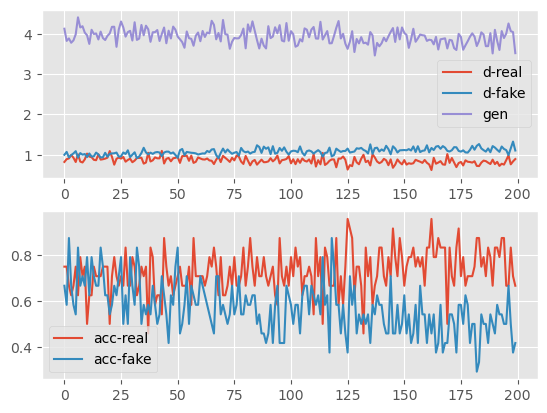

5677/5677 [==============================] - 79s 14ms/step
------------------------ KFold: 4 ---------------------------
The training dataset has 181961 records for the majority class and 315 records for the minority class.
The test dataset has 45490 records for the majority class and 79 records for the minority class.
Number of samples to be generated:  181646
Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_48 (Dense)            (None, 20)                620       
                                                                 
 dropout_32 (Dropout)        (None, 20)                0         
                                                                 
 leaky_re_lu_16 (LeakyReLU)  (None, 20)                0         
                                                                 
 dense_49 (Dense)            (None, 10)                210       
                   

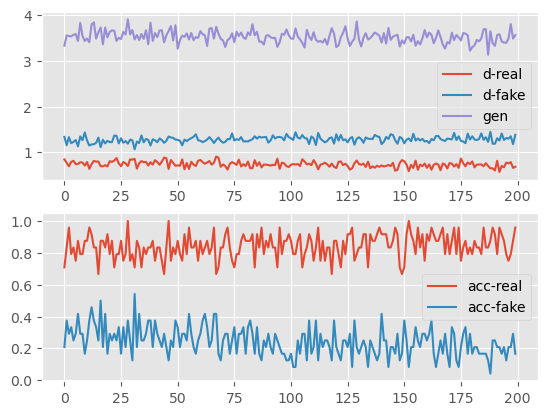

5677/5677 [==============================] - 123s 22ms/step
------------------------ KFold: 5 ---------------------------
The training dataset has 181961 records for the majority class and 315 records for the minority class.
The test dataset has 45490 records for the majority class and 79 records for the minority class.
Number of samples to be generated:  181646
Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_54 (Dense)            (None, 20)                620       
                                                                 
 dropout_36 (Dropout)        (None, 20)                0         
                                                                 
 leaky_re_lu_18 (LeakyReLU)  (None, 20)                0         
                                                                 
 dense_55 (Dense)            (None, 10)                210       
                  

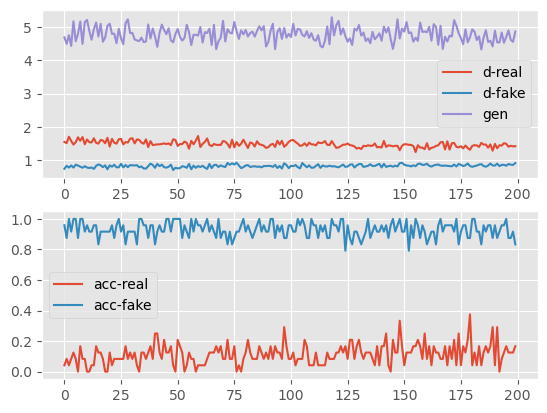

5677/5677 [==============================] - 28s 5ms/step
############################### Parameters tested: {'var_smoothing': 3.1622776601683795e-05} ################################
------------------------ KFold: 1 ---------------------------
The training dataset has 181960 records for the majority class and 316 records for the minority class.
The test dataset has 45491 records for the majority class and 78 records for the minority class.
Number of samples to be generated:  181644
Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_60 (Dense)            (None, 20)                620       
                                                                 
 dropout_40 (Dropout)        (None, 20)                0         
                                                                 
 leaky_re_lu_20 (LeakyReLU)  (None, 20)                0         
                          

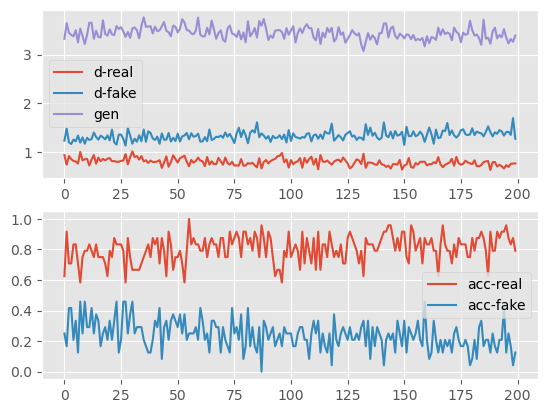

5677/5677 [==============================] - 29s 5ms/step
------------------------ KFold: 2 ---------------------------
The training dataset has 181961 records for the majority class and 315 records for the minority class.
The test dataset has 45490 records for the majority class and 79 records for the minority class.
Number of samples to be generated:  181646
Model: "sequential_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_66 (Dense)            (None, 20)                620       
                                                                 
 dropout_44 (Dropout)        (None, 20)                0         
                                                                 
 leaky_re_lu_22 (LeakyReLU)  (None, 20)                0         
                                                                 
 dense_67 (Dense)            (None, 10)                210       
                    

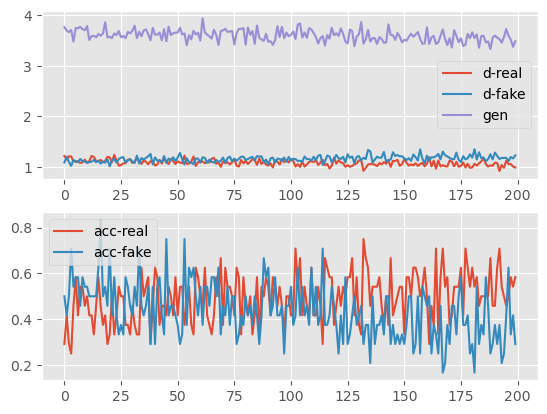

5677/5677 [==============================] - 39s 7ms/step
------------------------ KFold: 3 ---------------------------
The training dataset has 181961 records for the majority class and 315 records for the minority class.
The test dataset has 45490 records for the majority class and 79 records for the minority class.
Number of samples to be generated:  181646
Model: "sequential_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_72 (Dense)            (None, 20)                620       
                                                                 
 dropout_48 (Dropout)        (None, 20)                0         
                                                                 
 leaky_re_lu_24 (LeakyReLU)  (None, 20)                0         
                                                                 
 dense_73 (Dense)            (None, 10)                210       
                    

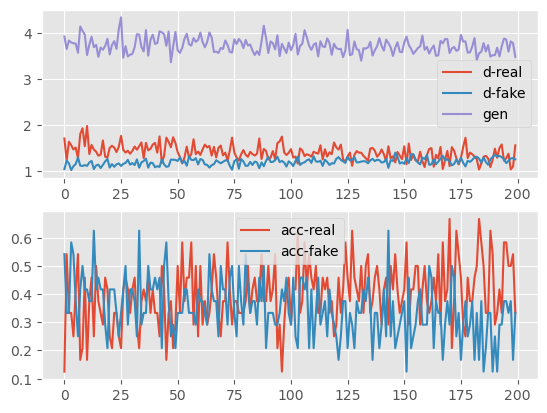

5677/5677 [==============================] - 86s 15ms/step
------------------------ KFold: 4 ---------------------------
The training dataset has 181961 records for the majority class and 315 records for the minority class.
The test dataset has 45490 records for the majority class and 79 records for the minority class.
Number of samples to be generated:  181646
Model: "sequential_39"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_78 (Dense)            (None, 20)                620       
                                                                 
 dropout_52 (Dropout)        (None, 20)                0         
                                                                 
 leaky_re_lu_26 (LeakyReLU)  (None, 20)                0         
                                                                 
 dense_79 (Dense)            (None, 10)                210       
                   

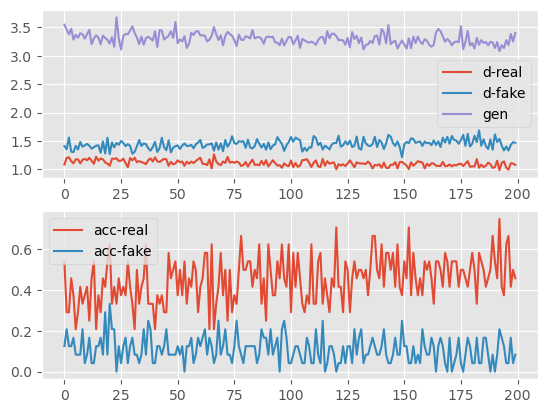

5677/5677 [==============================] - 413s 73ms/step
------------------------ KFold: 5 ---------------------------
The training dataset has 181961 records for the majority class and 315 records for the minority class.
The test dataset has 45490 records for the majority class and 79 records for the minority class.
Number of samples to be generated:  181646
Model: "sequential_42"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_84 (Dense)            (None, 20)                620       
                                                                 
 dropout_56 (Dropout)        (None, 20)                0         
                                                                 
 leaky_re_lu_28 (LeakyReLU)  (None, 20)                0         
                                                                 
 dense_85 (Dense)            (None, 10)                210       
                  

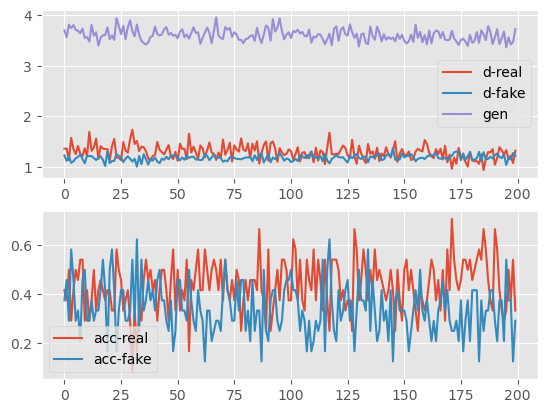

5677/5677 [==============================] - 113s 20ms/step
############################### Parameters tested: {'var_smoothing': 1.7782794100389227e-07} ################################
------------------------ KFold: 1 ---------------------------
The training dataset has 181960 records for the majority class and 316 records for the minority class.
The test dataset has 45491 records for the majority class and 78 records for the minority class.
Number of samples to be generated:  181644
Model: "sequential_45"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_90 (Dense)            (None, 20)                620       
                                                                 
 dropout_60 (Dropout)        (None, 20)                0         
                                                                 
 leaky_re_lu_30 (LeakyReLU)  (None, 20)                0         
                        

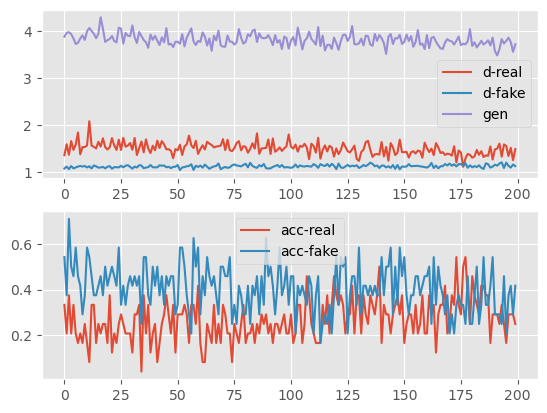

5677/5677 [==============================] - 139s 24ms/step
------------------------ KFold: 2 ---------------------------
The training dataset has 181961 records for the majority class and 315 records for the minority class.
The test dataset has 45490 records for the majority class and 79 records for the minority class.
Number of samples to be generated:  181646
Model: "sequential_48"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_96 (Dense)            (None, 20)                620       
                                                                 
 dropout_64 (Dropout)        (None, 20)                0         
                                                                 
 leaky_re_lu_32 (LeakyReLU)  (None, 20)                0         
                                                                 
 dense_97 (Dense)            (None, 10)                210       
                  

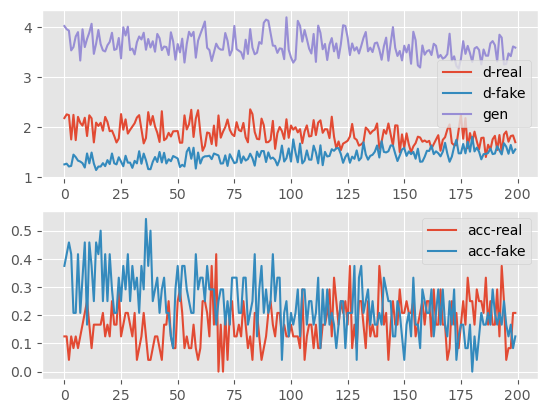

5677/5677 [==============================] - 350s 62ms/step
------------------------ KFold: 3 ---------------------------
The training dataset has 181961 records for the majority class and 315 records for the minority class.
The test dataset has 45490 records for the majority class and 79 records for the minority class.
Number of samples to be generated:  181646
Model: "sequential_51"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_102 (Dense)           (None, 20)                620       
                                                                 
 dropout_68 (Dropout)        (None, 20)                0         
                                                                 
 leaky_re_lu_34 (LeakyReLU)  (None, 20)                0         
                                                                 
 dense_103 (Dense)           (None, 10)                210       
                  

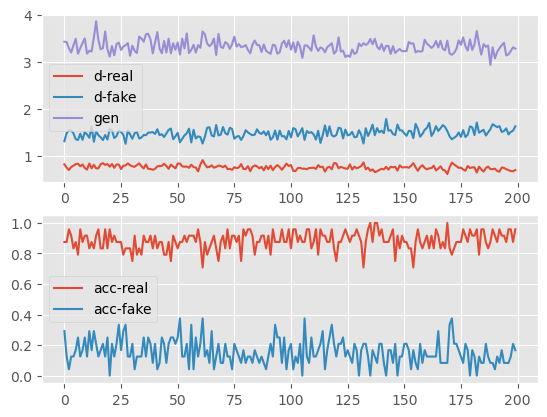

5677/5677 [==============================] - 501s 88ms/step
------------------------ KFold: 4 ---------------------------
The training dataset has 181961 records for the majority class and 315 records for the minority class.
The test dataset has 45490 records for the majority class and 79 records for the minority class.
Number of samples to be generated:  181646
Model: "sequential_54"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_108 (Dense)           (None, 20)                620       
                                                                 
 dropout_72 (Dropout)        (None, 20)                0         
                                                                 
 leaky_re_lu_36 (LeakyReLU)  (None, 20)                0         
                                                                 
 dense_109 (Dense)           (None, 10)                210       
                  

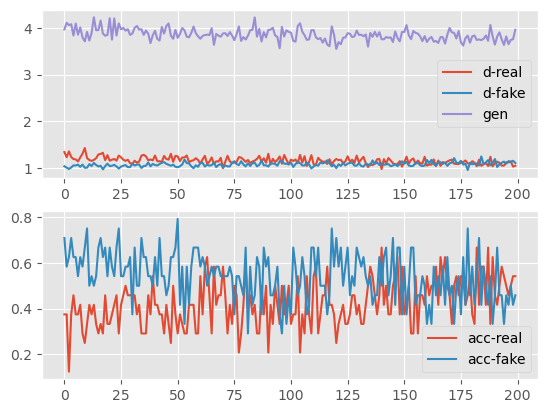

5677/5677 [==============================] - 490s 86ms/step
------------------------ KFold: 5 ---------------------------
The training dataset has 181961 records for the majority class and 315 records for the minority class.
The test dataset has 45490 records for the majority class and 79 records for the minority class.
Number of samples to be generated:  181646
Model: "sequential_57"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_114 (Dense)           (None, 20)                620       
                                                                 
 dropout_76 (Dropout)        (None, 20)                0         
                                                                 
 leaky_re_lu_38 (LeakyReLU)  (None, 20)                0         
                                                                 
 dense_115 (Dense)           (None, 10)                210       
                  

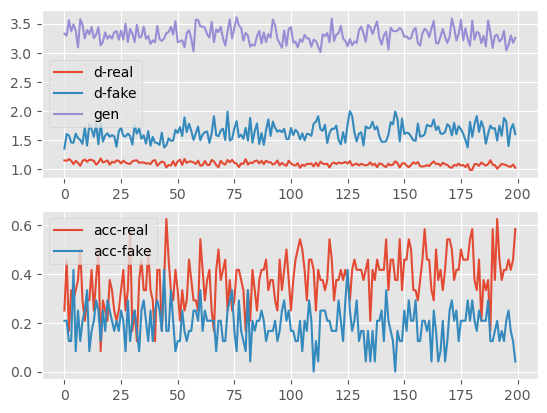

5677/5677 [==============================] - 667s 117ms/step
############################### Parameters tested: {'var_smoothing': 1e-09} ################################
------------------------ KFold: 1 ---------------------------
The training dataset has 181960 records for the majority class and 316 records for the minority class.
The test dataset has 45491 records for the majority class and 78 records for the minority class.
Number of samples to be generated:  181644
Model: "sequential_60"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_120 (Dense)           (None, 20)                620       
                                                                 
 dropout_80 (Dropout)        (None, 20)                0         
                                                                 
 leaky_re_lu_40 (LeakyReLU)  (None, 20)                0         
                                        

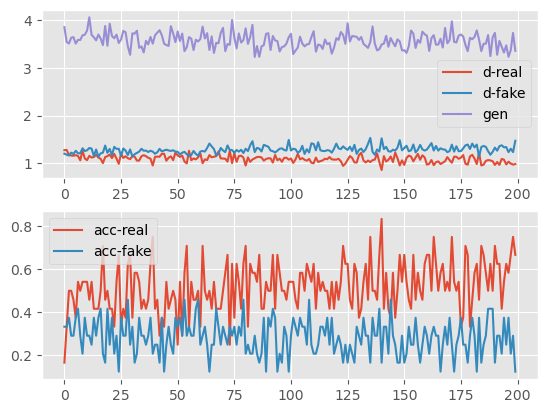

5677/5677 [==============================] - 601s 106ms/step
------------------------ KFold: 2 ---------------------------
The training dataset has 181961 records for the majority class and 315 records for the minority class.
The test dataset has 45490 records for the majority class and 79 records for the minority class.
Number of samples to be generated:  181646
Model: "sequential_63"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_126 (Dense)           (None, 20)                620       
                                                                 
 dropout_84 (Dropout)        (None, 20)                0         
                                                                 
 leaky_re_lu_42 (LeakyReLU)  (None, 20)                0         
                                                                 
 dense_127 (Dense)           (None, 10)                210       
                 

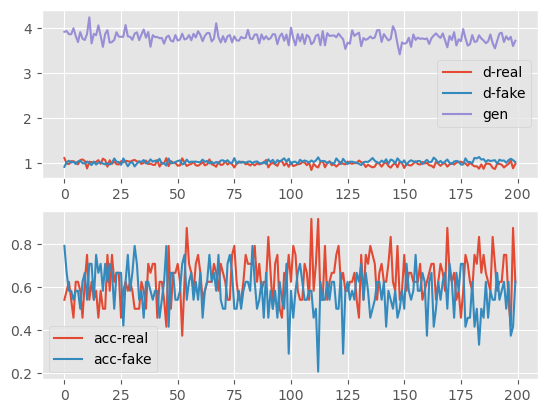

5677/5677 [==============================] - 587s 103ms/step
------------------------ KFold: 3 ---------------------------
The training dataset has 181961 records for the majority class and 315 records for the minority class.
The test dataset has 45490 records for the majority class and 79 records for the minority class.
Number of samples to be generated:  181646
Model: "sequential_66"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_132 (Dense)           (None, 20)                620       
                                                                 
 dropout_88 (Dropout)        (None, 20)                0         
                                                                 
 leaky_re_lu_44 (LeakyReLU)  (None, 20)                0         
                                                                 
 dense_133 (Dense)           (None, 10)                210       
                 

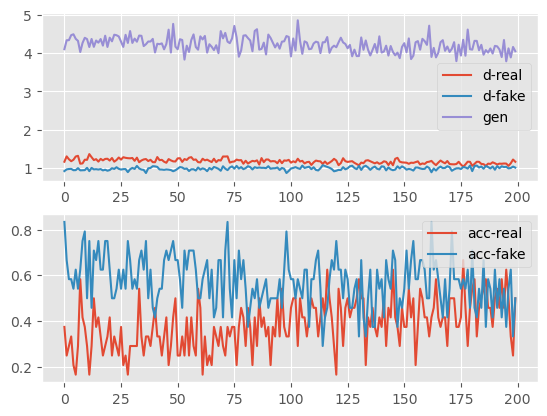

5677/5677 [==============================] - 620s 109ms/step
------------------------ KFold: 4 ---------------------------
The training dataset has 181961 records for the majority class and 315 records for the minority class.
The test dataset has 45490 records for the majority class and 79 records for the minority class.
Number of samples to be generated:  181646
Model: "sequential_69"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_138 (Dense)           (None, 20)                620       
                                                                 
 dropout_92 (Dropout)        (None, 20)                0         
                                                                 
 leaky_re_lu_46 (LeakyReLU)  (None, 20)                0         
                                                                 
 dense_139 (Dense)           (None, 10)                210       
                 

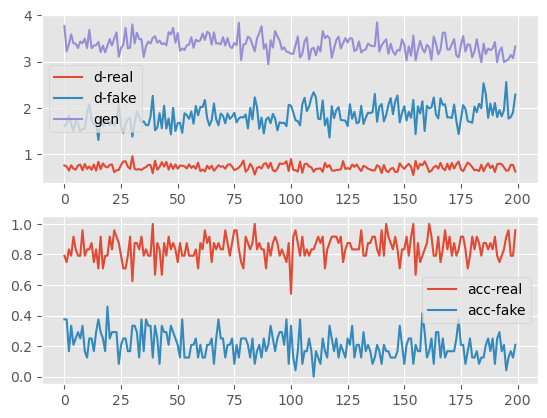

5677/5677 [==============================] - 117s 21ms/step
------------------------ KFold: 5 ---------------------------
The training dataset has 181961 records for the majority class and 315 records for the minority class.
The test dataset has 45490 records for the majority class and 79 records for the minority class.
Number of samples to be generated:  181646
Model: "sequential_72"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_144 (Dense)           (None, 20)                620       
                                                                 
 dropout_96 (Dropout)        (None, 20)                0         
                                                                 
 leaky_re_lu_48 (LeakyReLU)  (None, 20)                0         
                                                                 
 dense_145 (Dense)           (None, 10)                210       
                  

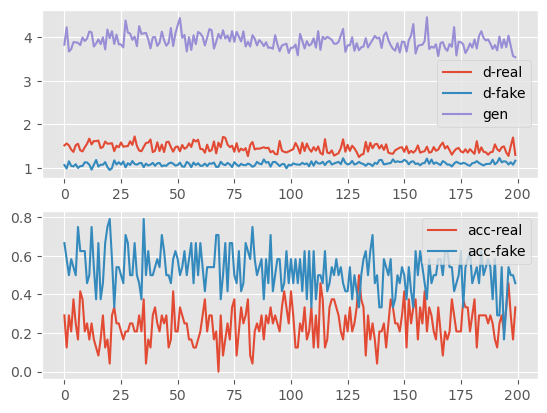

5677/5677 [==============================] - 119s 21ms/step


<Figure size 640x480 with 0 Axes>

In [6]:
#With hyperparameter tuning
#Cross validation
skf = StratifiedKFold(n_splits=5)

# Define the hyperparameters to tune
param_grid = {
    'var_smoothing': np.logspace(0,-9, num=5)
}


# Initialize variables to store the best hyperparameters and AUC score
best_params = {}
best_scores = []
best_f1 = -np.inf

# Iterate over all combinations of hyperparameters
for params in ParameterGrid(param_grid):
    lst_accuracy = []
    lst_precision = []
    lst_recall = []
    lst_f1_score = []
    lst_roc_auc_score = []
    
    f1_scores = []

    model = GaussianNB(var_smoothing=params['var_smoothing'])

    print("############################### Parameters tested:", params,"################################")
    for count, (train_index, valid_index) in enumerate(skf.split(X_train, y_train)):
        print("------------------------ KFold:", count+1, "---------------------------")
        X_train_fold, X_valid_fold = X_train.iloc[train_index], X_train.iloc[valid_index]
        y_train_fold, y_valid_fold = y_train.iloc[train_index], y_train.iloc[valid_index]

        print(f"The training dataset has {sorted(Counter(y_train_fold).items())[0][1]} records for the majority class and {sorted(Counter(y_train_fold).items())[1][1]} records for the minority class.")
        print(f"The test dataset has {sorted(Counter(y_valid_fold).items())[0][1]} records for the majority class and {sorted(Counter(y_valid_fold).items())[1][1]} records for the minority class.")
        
        maj = len(y_train_fold[y_train_fold == 0])
        mino = len(y_train_fold[y_train_fold == 1])
        frac = 0.5
        num_samples = round(1/(1/frac - 1) * maj - mino)

        print("Number of samples to be generated: ", num_samples)

        gan = GAN(input_dim= 30, 
              generator_output_dim=30, 
              discriminator_input_dim=30,
              noise_dim=100,
              num_samples=num_samples, 
              epochs=200, 
              batch_size=24,
              dropout=0.4)

        #Fit the VAE oversampling model and get new data set
        X_res_val,y_res_val = gan.fit_sample(X_train_fold,y_train_fold)
        
        std = StandardScaler()

        X_train_processed = std.fit_transform(X_res_val) 
        X_valid_processed = std.transform(X_valid_fold)

        model.fit(X_train_processed, y_res_val)

        y_pred_test = model.predict(X_valid_processed)

        lst_accuracy.append(accuracy_score(y_valid_fold, y_pred_test))
        lst_precision.append(precision_score(y_valid_fold, y_pred_test))
        lst_recall.append(recall_score(y_valid_fold, y_pred_test))
        lst_f1_score.append(f1_score(y_valid_fold, y_pred_test))
        lst_roc_auc_score.append(roc_auc_score(y_valid_fold, y_pred_test))


    avg_f1 = np.mean(lst_f1_score)

    if avg_f1 > best_f1:
        best_f1 = avg_f1
        best_scores = [lst_accuracy, lst_precision, lst_recall, lst_f1_score, lst_roc_auc_score]
        best_params = params



In [7]:
# Print the best AUC score and hyperparameters
print(f"Accuracy:, {np.mean(best_scores[0]):0.6f} (+/- {np.std(best_scores[0]):0.6f})")
print(f"Precision: {np.mean(best_scores[1]):0.6f} (+/- {np.std(best_scores[1]):0.6f})")
print(f"Recall: {np.mean(best_scores[2]):0.6f} (+/- {np.std(best_scores[2]):0.6f})")
print(f"F1 score: {np.mean(best_scores[3]):0.6f} (+/- {np.std(best_scores[3]):0.6f})")
print(f"ROC_AUC: {np.mean(best_scores[4]):0.6f} (+/- {np.std(best_scores[4]):0.6f})")
print("Best hyperparameters:", best_params)

Accuracy:, 0.998999 (+/- 0.000139)
Precision: 0.736656 (+/- 0.063193)
Recall: 0.669912 (+/- 0.030588)
F1 score: 0.699343 (+/- 0.027670)
ROC_AUC: 0.834741 (+/- 0.015249)
Best hyperparameters: {'var_smoothing': 1.0}


### Cross Validation

------------------------ KFold: 1 ---------------------------
The training dataset has 181960 records for the majority class and 316 records for the minority class.
The test dataset has 45491 records for the majority class and 78 records for the minority class.
NUmber of samples to be generated:  181644
Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_161 (Dense)           (None, 20)                620       
                                                                 
 dropout_24 (Dropout)        (None, 20)                0         
                                                                 
 leaky_re_lu_12 (LeakyReLU)  (None, 20)                0         
                                                                 
 dense_162 (Dense)           (None, 10)                210       
                                                                 
 dropout_25 

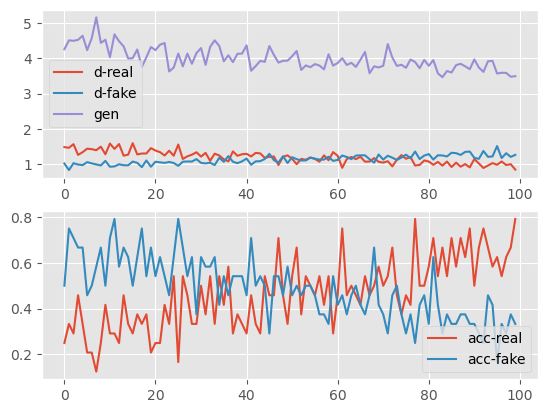

5677/5677 [==============================] - 45s 8ms/step
------------------------ KFold: 2 ---------------------------
The training dataset has 181961 records for the majority class and 315 records for the minority class.
The test dataset has 45490 records for the majority class and 79 records for the minority class.
NUmber of samples to be generated:  181646
Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_167 (Dense)           (None, 20)                620       
                                                                 
 dropout_28 (Dropout)        (None, 20)                0         
                                                                 
 leaky_re_lu_14 (LeakyReLU)  (None, 20)                0         
                                                                 
 dense_168 (Dense)           (None, 10)                210       
                    

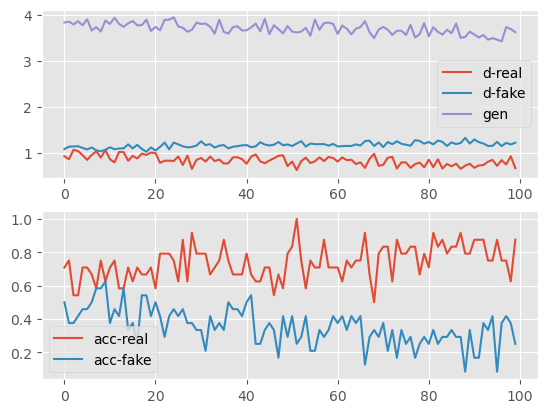

5677/5677 [==============================] - 28s 5ms/step
------------------------ KFold: 3 ---------------------------
The training dataset has 181961 records for the majority class and 315 records for the minority class.
The test dataset has 45490 records for the majority class and 79 records for the minority class.
NUmber of samples to be generated:  181646
Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_173 (Dense)           (None, 20)                620       
                                                                 
 dropout_32 (Dropout)        (None, 20)                0         
                                                                 
 leaky_re_lu_16 (LeakyReLU)  (None, 20)                0         
                                                                 
 dense_174 (Dense)           (None, 10)                210       
                    

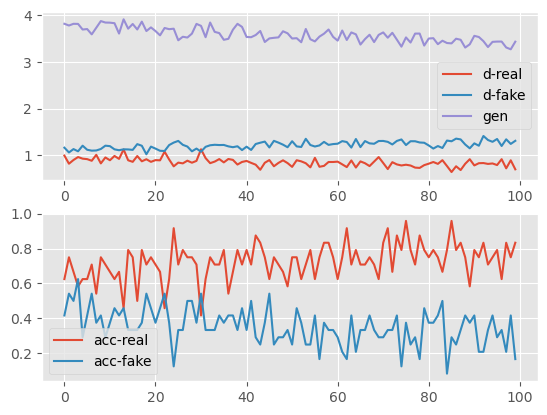

5677/5677 [==============================] - 26s 5ms/step
------------------------ KFold: 4 ---------------------------
The training dataset has 181961 records for the majority class and 315 records for the minority class.
The test dataset has 45490 records for the majority class and 79 records for the minority class.
NUmber of samples to be generated:  181646
Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_179 (Dense)           (None, 20)                620       
                                                                 
 dropout_36 (Dropout)        (None, 20)                0         
                                                                 
 leaky_re_lu_18 (LeakyReLU)  (None, 20)                0         
                                                                 
 dense_180 (Dense)           (None, 10)                210       
                    

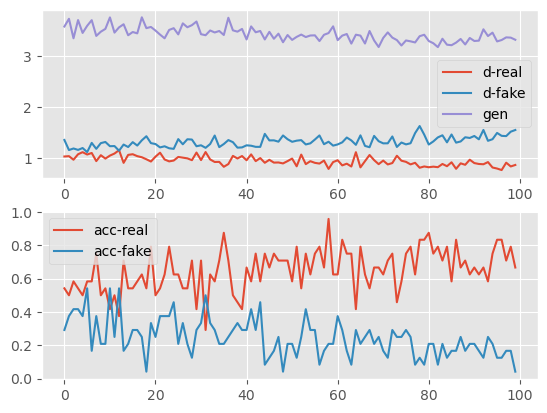

5677/5677 [==============================] - 27s 5ms/step
------------------------ KFold: 5 ---------------------------
The training dataset has 181961 records for the majority class and 315 records for the minority class.
The test dataset has 45490 records for the majority class and 79 records for the minority class.
NUmber of samples to be generated:  181646
Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_185 (Dense)           (None, 20)                620       
                                                                 
 dropout_40 (Dropout)        (None, 20)                0         
                                                                 
 leaky_re_lu_20 (LeakyReLU)  (None, 20)                0         
                                                                 
 dense_186 (Dense)           (None, 10)                210       
                    

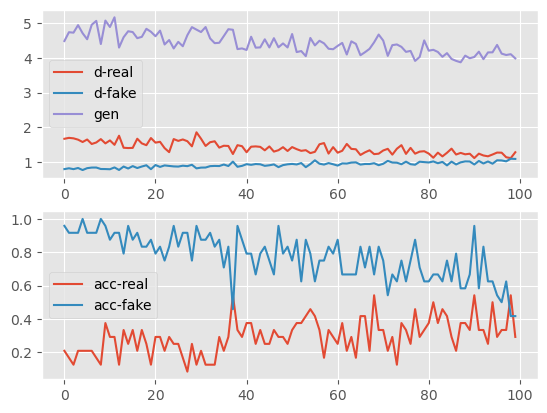

5677/5677 [==============================] - 26s 5ms/step


<Figure size 640x480 with 0 Axes>

In [29]:
#Cross validation
skf = StratifiedKFold(n_splits=5)
lst_accuracy = []
lst_precision = []
lst_recall = []
lst_f1_score = []
lst_roc_auc_score = []

model = GaussianNB()

for count, (train_index, valid_index) in enumerate(skf.split(X_train, y_train)):
    print("------------------------ KFold:", count+1, "---------------------------")
    X_train_fold, X_valid_fold = X_train.iloc[train_index], X_train.iloc[valid_index]
    y_train_fold, y_valid_fold = y_train.iloc[train_index], y_train.iloc[valid_index]

    print(f"The training dataset has {sorted(Counter(y_train_fold).items())[0][1]} records for the majority class and {sorted(Counter(y_train_fold).items())[1][1]} records for the minority class.")
    print(f"The test dataset has {sorted(Counter(y_valid_fold).items())[0][1]} records for the majority class and {sorted(Counter(y_valid_fold).items())[1][1]} records for the minority class.")
    
    maj = len(y_train_fold[y_train_fold == 0])
    mino = len(y_train_fold[y_train_fold == 1])
    frac = 0.5
    num_samples = round(1/(1/frac - 1) * maj - mino)

    print("NUmber of samples to be generated: ", num_samples)
    
    gan = GAN(input_dim= 30, 
              generator_output_dim=30, 
              discriminator_input_dim=30,
              noise_dim=100,
              num_samples=num_samples, 
              epochs=100, 
              batch_size=24,
              dropout=0.4)

    #Fit the GAN oversampling model and get new data set
    X_res_val_gan,y_res_val_gan = gan.fit_sample(X_train_fold, y_train_fold)

    std = StandardScaler()
    
    X_train_processed = std.fit_transform(X_res_val_gan) 
    X_valid_processed = std.transform(X_valid_fold)

    model.fit(X_train_processed, y_res_val_gan)

    y_pred_test = model.predict(X_valid_processed)

    lst_accuracy.append(accuracy_score(y_valid_fold, y_pred_test))
    lst_precision.append(precision_score(y_valid_fold, y_pred_test))
    lst_recall.append(recall_score(y_valid_fold, y_pred_test))
    lst_f1_score.append(f1_score(y_valid_fold, y_pred_test))
    lst_roc_auc_score.append(roc_auc_score(y_valid_fold, y_pred_test))


In [30]:
print(f"Accuracy:, {np.mean(lst_accuracy):0.6f} (+/- {np.std(lst_accuracy):0.6f})")
print(f"Precision: {np.mean(lst_precision):0.6f} (+/- {np.std(lst_precision):0.6f})")
print(f"Recall: {np.mean(lst_recall):0.6f} (+/- {np.std(lst_recall):0.6f})")
print(f"F1 score: {np.mean(lst_f1_score):0.6f} (+/- {np.std(lst_f1_score):0.6f})")
print(f"ROC_AUC: {np.mean(lst_roc_auc_score):0.6f} (+/- {np.std(lst_roc_auc_score):0.6f})")

Accuracy:, 0.998740 (+/- 0.000285)
Precision: 0.654837 (+/- 0.117344)
Recall: 0.621908 (+/- 0.074449)
F1 score: 0.632654 (+/- 0.071019)
ROC_AUC: 0.810651 (+/- 0.037219)


### One fit

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_155 (Dense)           (None, 20)                620       
                                                                 
 dropout_20 (Dropout)        (None, 20)                0         
                                                                 
 leaky_re_lu_10 (LeakyReLU)  (None, 20)                0         
                                                                 
 dense_156 (Dense)           (None, 10)                210       
                                                                 
 dropout_21 (Dropout)        (None, 10)                0         
                                                                 
 leaky_re_lu_11 (LeakyReLU)  (None, 10)                0         
                                                                 
 dense_157 (Dense)           (None, 1)               

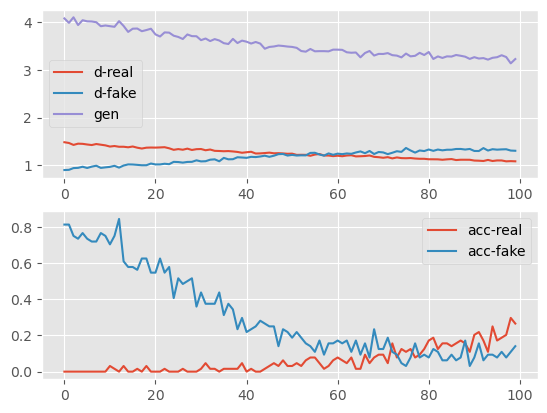

7096/7096 [==============================] - 21s 3ms/step


<Figure size 640x480 with 0 Axes>

In [27]:
maj = len(y_train[y_train == 0])
mino = len(y_train[y_train == 1])
frac = 0.5
num_samples = round(1/(1/frac - 1) * maj - mino)

gan = GAN(input_dim= 30, 
            generator_output_dim=30, 
            discriminator_input_dim=30,
            noise_dim=100,
            num_samples=num_samples, 
            epochs=100, 
            batch_size=64,
            dropout=0.1)

#Fit the GAN oversampling model and get new data set
X_res_val_gan,y_res_val_gan = gan.fit_sample(X_train, y_train)

std = StandardScaler()

X_train_processed_gan = std.fit_transform(X_res_val_gan)
X_test_processed_gan = std.transform(X_test)

In [28]:
logReg_vae = GaussianNB()

logReg_vae.fit(X_train_processed_gan, y_res_val_gan)

#predict
pred_lr_vae_val = logReg_vae.predict(X_test_processed_gan)

model_scores(y_test, pred_lr_vae_val)

Accuracy: 0.9988413328183702
Precision: 0.7
Recall: 0.5714285714285714
F1 score: 0.6292134831460674
ROC_AUC: 0.785503255888737
